## Ratio/Outlier Diagnostics
Standalone plots for the deviation-based analysis.


In [1]:
from __future__ import annotations
from pathlib import Path
import os
os.chdir("../../..")
import yaml
import numpy as np
import pandas as pd

from FLAME.io_fronts import Case, load_fronts


In [2]:
PROJECT_ROOT = Path.cwd().resolve()
CONFIG_PATH = PROJECT_ROOT / "notebooks" / "case_studies" / "tests" / "tests.yaml"
CFG = yaml.safe_load(CONFIG_PATH.read_text(encoding="utf-8"))

DATA_BASE_DIR = PROJECT_ROOT / Path(CFG["BASE_DIR"])
PHI = float(CFG["PHI"])
LAT_SIZE = str(CFG["LAT_SIZE"])
TIME_STEPS = list(CFG["TIME_STEPS"])
PROGRESS_LEVELS = list(CFG["PROGRESS_LEVELS"])
POST = bool(CFG["POST"])
MULTIPLE_RUNS = bool(CFG["MULTIPLE_RUNS"])
N_RUN = int(CFG["N_RUN"])
CURVATURE_COLUMN = str(CFG["CURVATURE_COLUMN"])

REPORT_BASE_DIR = PROJECT_ROOT / Path(CFG["OUT_BASE_DIR"])

PHI_TAG = f"phi_{PHI:g}"
LAT_TAG = f"h400x{LAT_SIZE}_ref"

def _time_steps_tag(time_steps: list[int]) -> str:
    if not time_steps:
        return "t_none"
    if len(time_steps) == 1:
        return f"t_{time_steps[0]}"
    t_min = min(time_steps)
    t_max = max(time_steps)
    return f"t_{t_min}_to_{t_max}"

OUT_BASE_DIR = REPORT_BASE_DIR / PHI_TAG / LAT_TAG / _time_steps_tag(TIME_STEPS)

# ------------------------------------------------------------
# Plot style
# ------------------------------------------------------------
import matplotlib.pyplot as plt

PLOT_FONT_FAMILY = str(CFG.get("PLOT_FONT_FAMILY", "Courier New"))
PLOT_FONT_SIZE = int(CFG.get("PLOT_FONT_SIZE", 20))
FIG_DPI = int(CFG.get("FIG_DPI", 250))
FIG_SIZE_RAW = CFG.get("FIG_SIZE", (6.8, 6.2))
if isinstance(FIG_SIZE_RAW, (list, tuple)) and len(FIG_SIZE_RAW) == 2:
    FIG_SIZE = (float(FIG_SIZE_RAW[0]), float(FIG_SIZE_RAW[1]))
else:
    FIG_SIZE = (6.8, 6.2)

PLOT_USE_TEX = bool(CFG.get("PLOT_USE_TEX", False))
PLOT_TEX_PREAMBLE_RAW = CFG.get("PLOT_TEX_PREAMBLE", "")
if isinstance(PLOT_TEX_PREAMBLE_RAW, (list, tuple)):
    PLOT_TEX_PREAMBLE = "\n".join(str(item) for item in PLOT_TEX_PREAMBLE_RAW if item)
else:
    PLOT_TEX_PREAMBLE = str(PLOT_TEX_PREAMBLE_RAW) if PLOT_TEX_PREAMBLE_RAW is not None else ""

def apply_plot_style() -> None:
    params = {
        "font.family": PLOT_FONT_FAMILY,
        "font.size": PLOT_FONT_SIZE,
        "axes.titlesize": PLOT_FONT_SIZE,
        "axes.labelsize": PLOT_FONT_SIZE,
        "xtick.labelsize": PLOT_FONT_SIZE,
        "ytick.labelsize": PLOT_FONT_SIZE,
        "legend.fontsize": PLOT_FONT_SIZE,
        "figure.titlesize": PLOT_FONT_SIZE,
        "axes.linewidth": 1.2,
        "text.usetex": PLOT_USE_TEX,
    }
    if PLOT_TEX_PREAMBLE:
        params["text.latex.preamble"] = PLOT_TEX_PREAMBLE
    plt.rcParams.update(params)

apply_plot_style()

COLOR_DATA = str(CFG.get("COLOR_DATA", "#77b5b6"))
COLOR_DATA_EDGE = str(CFG.get("COLOR_DATA_EDGE", "#378d94"))
COLOR_PRED = str(CFG.get("COLOR_PRED", "#9671bd"))
COLOR_PRED_EDGE = str(CFG.get("COLOR_PRED_EDGE", "#6a408d"))
COLOR_NEUTRAL = str(CFG.get("COLOR_NEUTRAL", "#7e7e7e"))
COLOR_LINE = str(CFG.get("COLOR_LINE", "#8a8a8a"))

LABEL_CURV = r"$\kappa^*$"
LABEL_STRETCH = r"$\mathbb{K}^*$"
LABEL_SD = r"$\tilde{S}_d^*$"




def style_axes(ax, *, equal: bool = False) -> None:
    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle="-", linewidth=0.75, alpha=0.25)
    ax.grid(True, which="minor", linestyle="-", linewidth=0.25, alpha=0.15)
    ax.tick_params(axis="both", which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="both", which="major", length=6, width=1.0)
    ax.tick_params(axis="both", which="minor", length=3, width=0.8)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    if equal:
        ax.set_aspect("equal", adjustable="box")

def save_multi_fig(fig, base: Path, suffix: str) -> None:
    out = base.with_name(f"{base.name}_{suffix}")
    fig.savefig(out.with_suffix(".png"), dpi=FIG_DPI)
    fig.savefig(out.with_suffix(".pdf"))
    fig.savefig(out.with_suffix(".svg"))

# ------------------------------------------------------------
# Helpers
# ------------------------------------------------------------
def make_case(time_step: int) -> Case:
    base_kwargs = dict(
        base_dir=DATA_BASE_DIR,
        phi=PHI,
        lat_size=LAT_SIZE,
        time_step=time_step,
        post=POST,
    )
    try:
        return Case(
            **base_kwargs,
            multiple_runs=MULTIPLE_RUNS,
            n_run=N_RUN
        )
    except TypeError:
        return Case(**base_kwargs)

def require_columns(df: pd.DataFrame, cols: list[str], context: str = "") -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise ValueError(f"{context} Missing columns: {missing}")

def clean_valid_rows(df: pd.DataFrame, cols_needed: list[str]) -> pd.DataFrame:
    valid = df[cols_needed].replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")
    return df.loc[valid.index].copy()


### Ratio/outlier diagnostics

Equations used:

- $ r = (\text{stretch_rate} - \text{strain_rate}) / \text{curvature} $
- $S_d^* = \text{DW_FDS} \cdot \sigma$ (with $\sigma=\text{density_ratio_sigma}$)
- $\Delta = S_d^* - r$
- Outliers: $|\Delta| > \text{DEVIATION_THRESHOLD}$
- 1:1 reference line: $y = x$


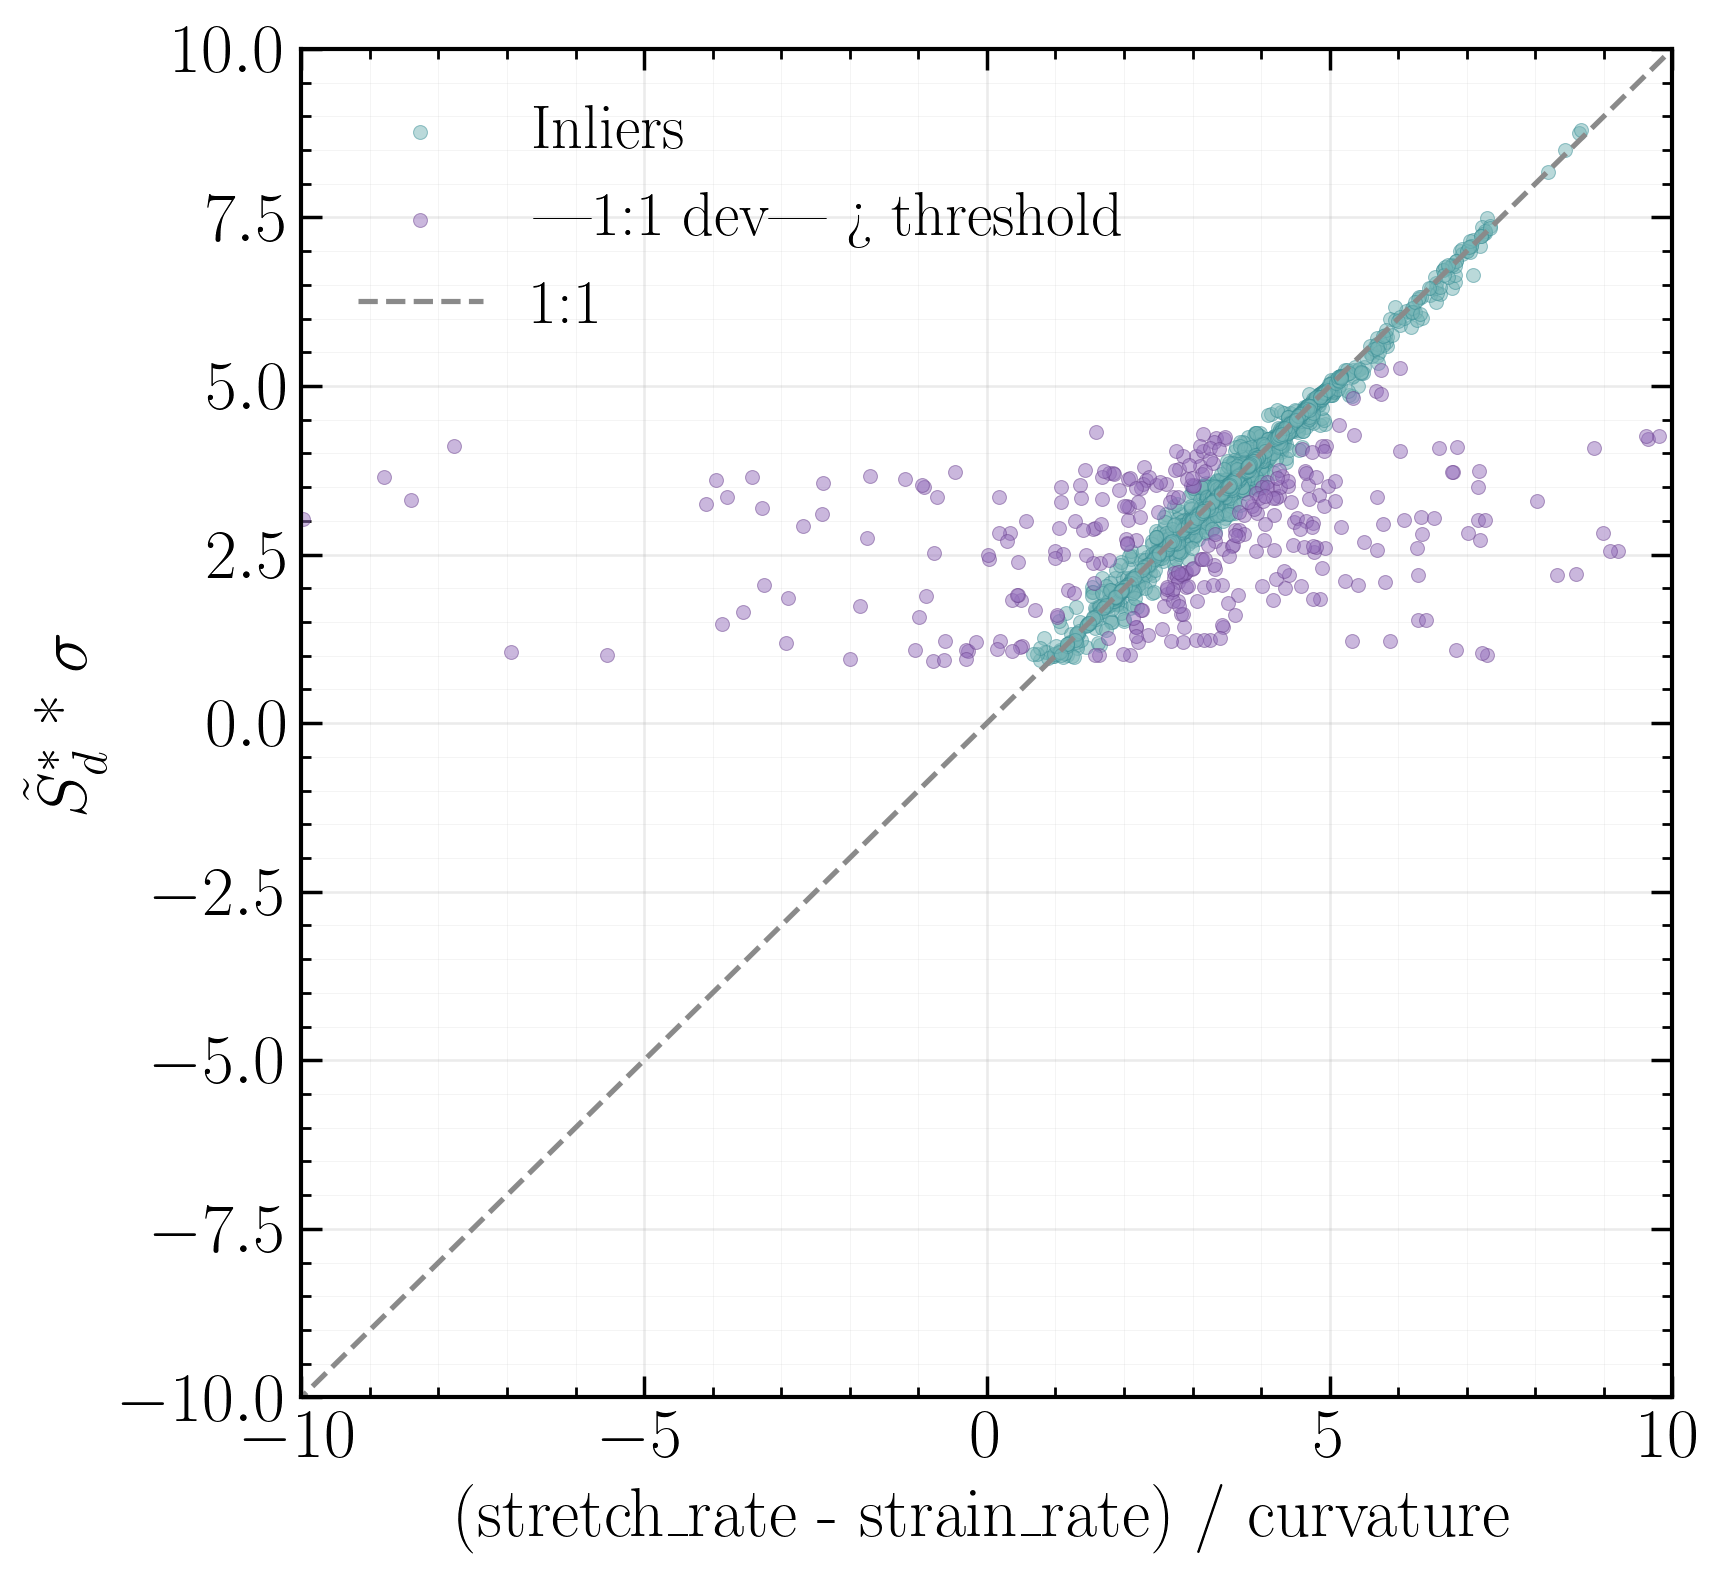

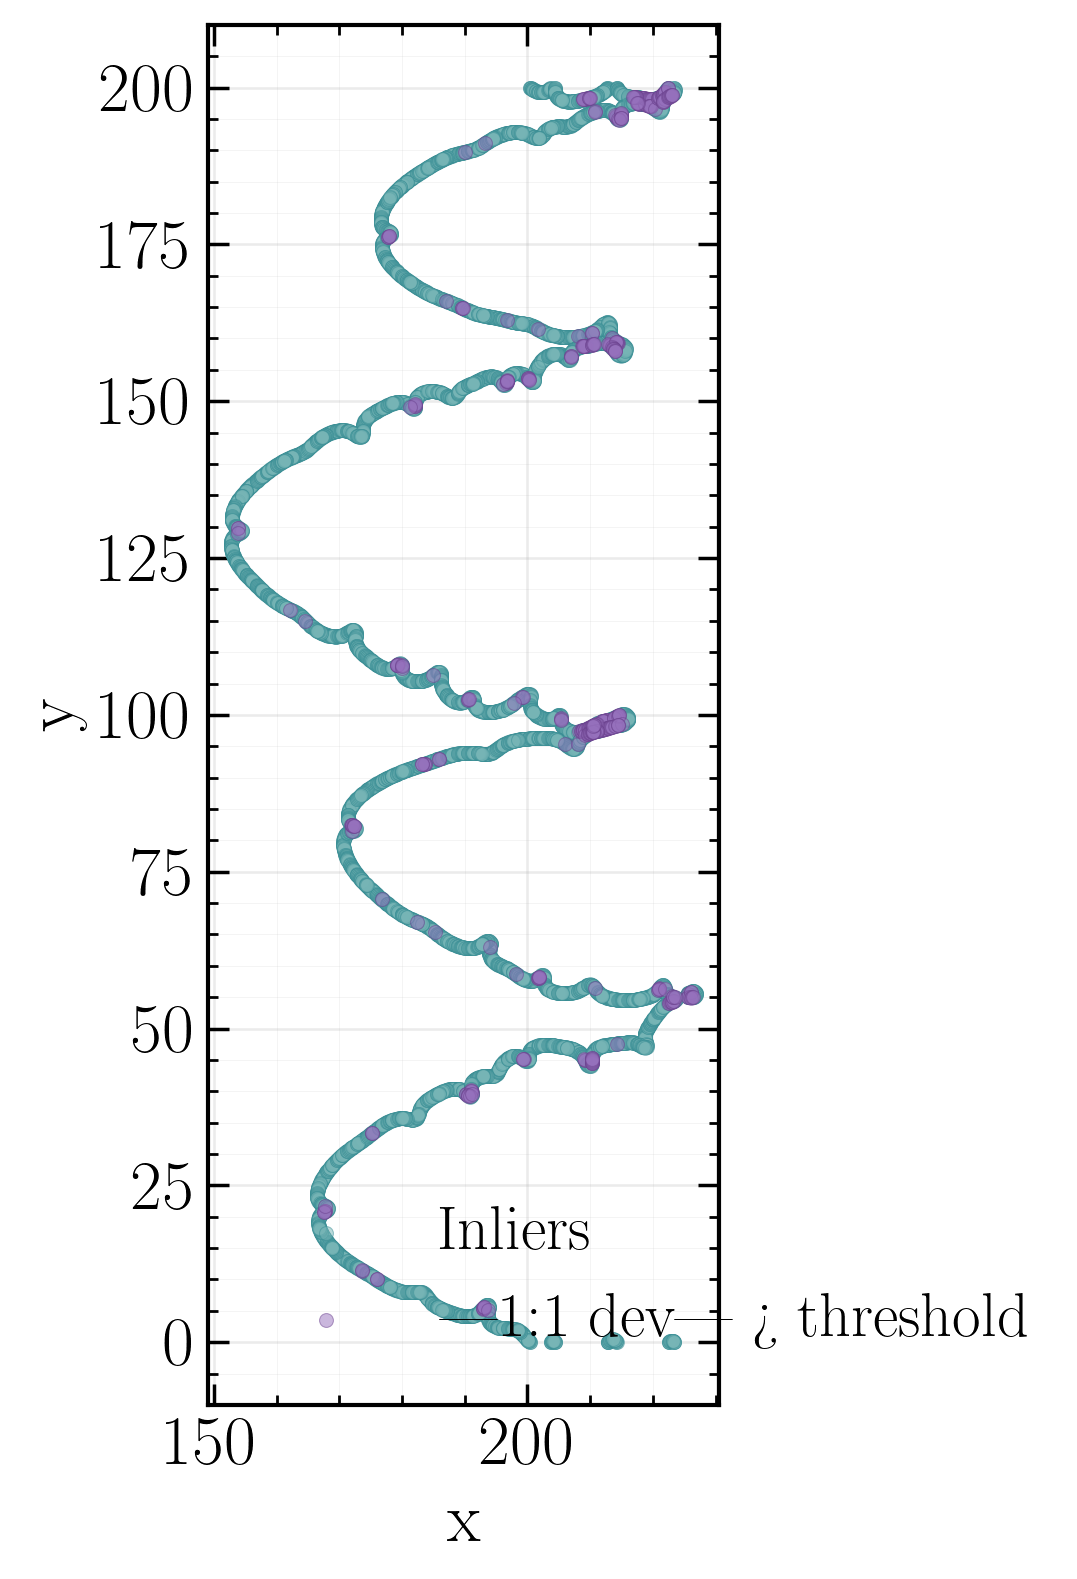

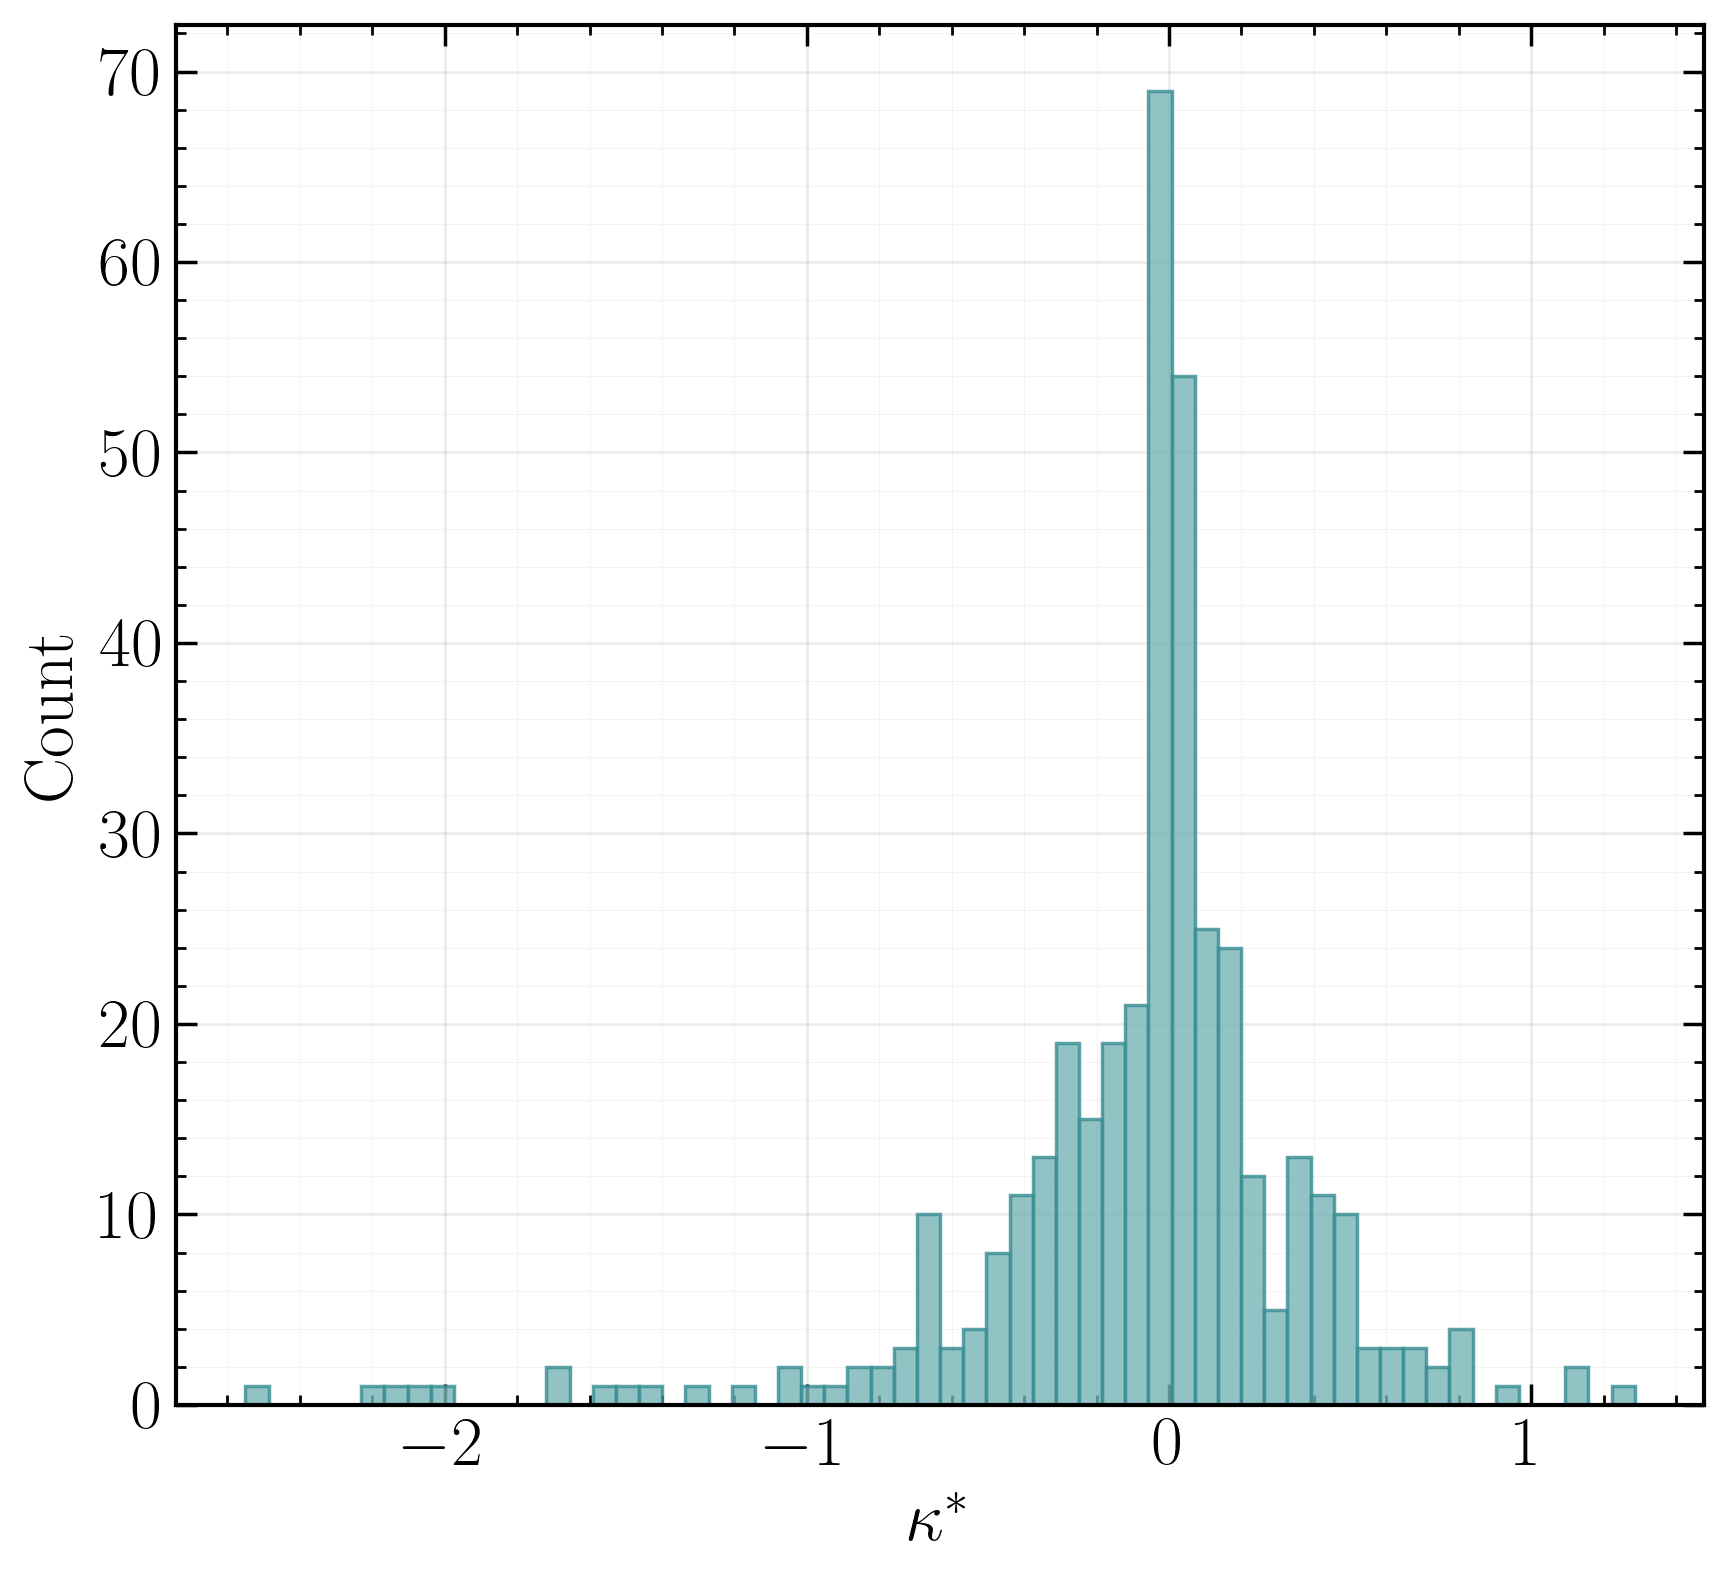

In [3]:
# Compute (stretch_rate - strain_rate) / curvature over the full dataset and plot vs Sd
import matplotlib.pyplot as plt
from FLAME.io_fields import load_field_csv

RATIO_COLUMN = "stretch_minus_strain_over_curvature"
STRETCH_COLUMN = "stretch_rate"
STRAIN_COLUMN = "strain_rate"
TARGET_COLUMN = "DW_FDS"
DENSITY_COLUMN = "density_ratio_sigma"
X_COLUMN = "x"
Y_COLUMN = "y"
GRAD_T_COLUMN = "gradT"
GRAD_T_NORMAL_COLUMN = "gradT_normal"
DEVIATION_THRESHOLD = 0.5
CURV_EPS = 1.0e-12

SAVE_RATIO_PLOT = True
RATIO_OUT_DIR = OUT_BASE_DIR / "ratio_plots"
RATIO_SCATTER_S = 16
RATIO_ALPHA = 0.5
MAX_RATIO_POINTS = 200000
LINE_WIDTH = 1.5
HIST_BINS = 60

ratio_frames = []
for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)

    for c_val, front in fronts_t.items():
        front = front.copy()
        need_cols = [
            CURVATURE_COLUMN,
            STRETCH_COLUMN,
            STRAIN_COLUMN,
            TARGET_COLUMN,
            DENSITY_COLUMN,
            X_COLUMN,
            Y_COLUMN,
            GRAD_T_COLUMN,
            GRAD_T_NORMAL_COLUMN,
        ]
        require_columns(front, need_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, need_cols)
        dfv = dfv[dfv[CURVATURE_COLUMN].abs() > CURV_EPS].copy()
        dfv[RATIO_COLUMN] = (dfv[STRETCH_COLUMN] - dfv[STRAIN_COLUMN]) / dfv[CURVATURE_COLUMN]
        ratio_frames.append(
            dfv[[
                RATIO_COLUMN,
                TARGET_COLUMN,
                DENSITY_COLUMN,
                X_COLUMN,
                Y_COLUMN,
                CURVATURE_COLUMN,
                GRAD_T_COLUMN,
                GRAD_T_NORMAL_COLUMN,
            ]]
        )

if ratio_frames:
    ratio_df = pd.concat(ratio_frames, ignore_index=True)
    if len(ratio_df) > MAX_RATIO_POINTS:
        ratio_df = ratio_df.sample(MAX_RATIO_POINTS, random_state=42)

    ratio_df["sd_weighted"] = ratio_df[TARGET_COLUMN] * ratio_df[DENSITY_COLUMN]
    ratio_df["ratio_deviation"] = ratio_df["sd_weighted"] - ratio_df[RATIO_COLUMN]
    outlier_mask = ratio_df["ratio_deviation"].abs() > DEVIATION_THRESHOLD

    fig, ax = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax.scatter(
        ratio_df.loc[~outlier_mask, RATIO_COLUMN],
        ratio_df.loc[~outlier_mask, "sd_weighted"],
        s=RATIO_SCATTER_S,
        alpha=RATIO_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.3,
        label="Inliers",
    )
    ax.scatter(
        ratio_df.loc[outlier_mask, RATIO_COLUMN],
        ratio_df.loc[outlier_mask, "sd_weighted"],
        s=RATIO_SCATTER_S,
        alpha=RATIO_ALPHA,
        color=COLOR_PRED,
        edgecolors=COLOR_PRED_EDGE,
        linewidths=0.3,
        label="|1:1 dev| > threshold",
    )
    lim_min = float(min(ratio_df[RATIO_COLUMN].min(), ratio_df["sd_weighted"].min()))
    lim_max = float(max(ratio_df[RATIO_COLUMN].max(), ratio_df["sd_weighted"].max()))
    ax.plot([lim_min, lim_max], [lim_min, lim_max], linestyle="--", color=COLOR_LINE, linewidth=LINE_WIDTH, label="1:1")

    ax.set_xlabel("(stretch_rate - strain_rate) / curvature")
    ax.set_ylabel(f"{LABEL_SD} * $\sigma$")
    ax.legend(frameon=False, fontsize=PLOT_FONT_SIZE - 2)
    ax.set_xlim((-10,10))
    ax.set_ylim((-10,10))
    style_axes(ax)

    # XY isocontour scatter with outlier highlighting
    fig_xy, ax_xy = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
    ax_xy.scatter(
        ratio_df.loc[~outlier_mask, X_COLUMN],
        ratio_df.loc[~outlier_mask, Y_COLUMN],
        s=RATIO_SCATTER_S,
        alpha=RATIO_ALPHA,
        color=COLOR_DATA,
        edgecolors=COLOR_DATA_EDGE,
        linewidths=0.3,
        label="Inliers",
    )
    ax_xy.scatter(
        ratio_df.loc[outlier_mask, X_COLUMN],
        ratio_df.loc[outlier_mask, Y_COLUMN],
        s=RATIO_SCATTER_S,
        alpha=RATIO_ALPHA,
        color=COLOR_PRED,
        edgecolors=COLOR_PRED_EDGE,
        linewidths=0.3,
        label="|1:1 dev| > threshold",
    )
    ax_xy.set_xlabel("x")
    ax_xy.set_ylabel("y")
    ax_xy.legend(frameon=False, fontsize=PLOT_FONT_SIZE - 2)
    style_axes(ax_xy, equal=True)
    plt.show()
    plt.close(fig_xy)

    # Curvature histogram for outliers
    curv_out = ratio_df.loc[outlier_mask, CURVATURE_COLUMN].to_numpy()
    if curv_out.size > 0:
        fig_hist, ax_hist = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
        ax_hist.hist(
            curv_out,
            bins=HIST_BINS,
            color=COLOR_DATA,
            edgecolor=COLOR_DATA_EDGE,
            alpha=0.8,
        )
        ax_hist.set_xlabel(LABEL_CURV)
        ax_hist.set_ylabel("Count")
        style_axes(ax_hist)
        plt.show()
        plt.close(fig_hist)

    if SAVE_RATIO_PLOT:
        RATIO_OUT_DIR.mkdir(parents=True, exist_ok=True)
        save_multi_fig(fig, RATIO_OUT_DIR / "sd_vs_stretch_minus_strain_over_curvature", "scatter")
    plt.show()
    plt.close(fig)
else:
    print("No valid rows for ratio plot.")


### gradT vs gradT_normal

Reference curve: $y = |x|$.


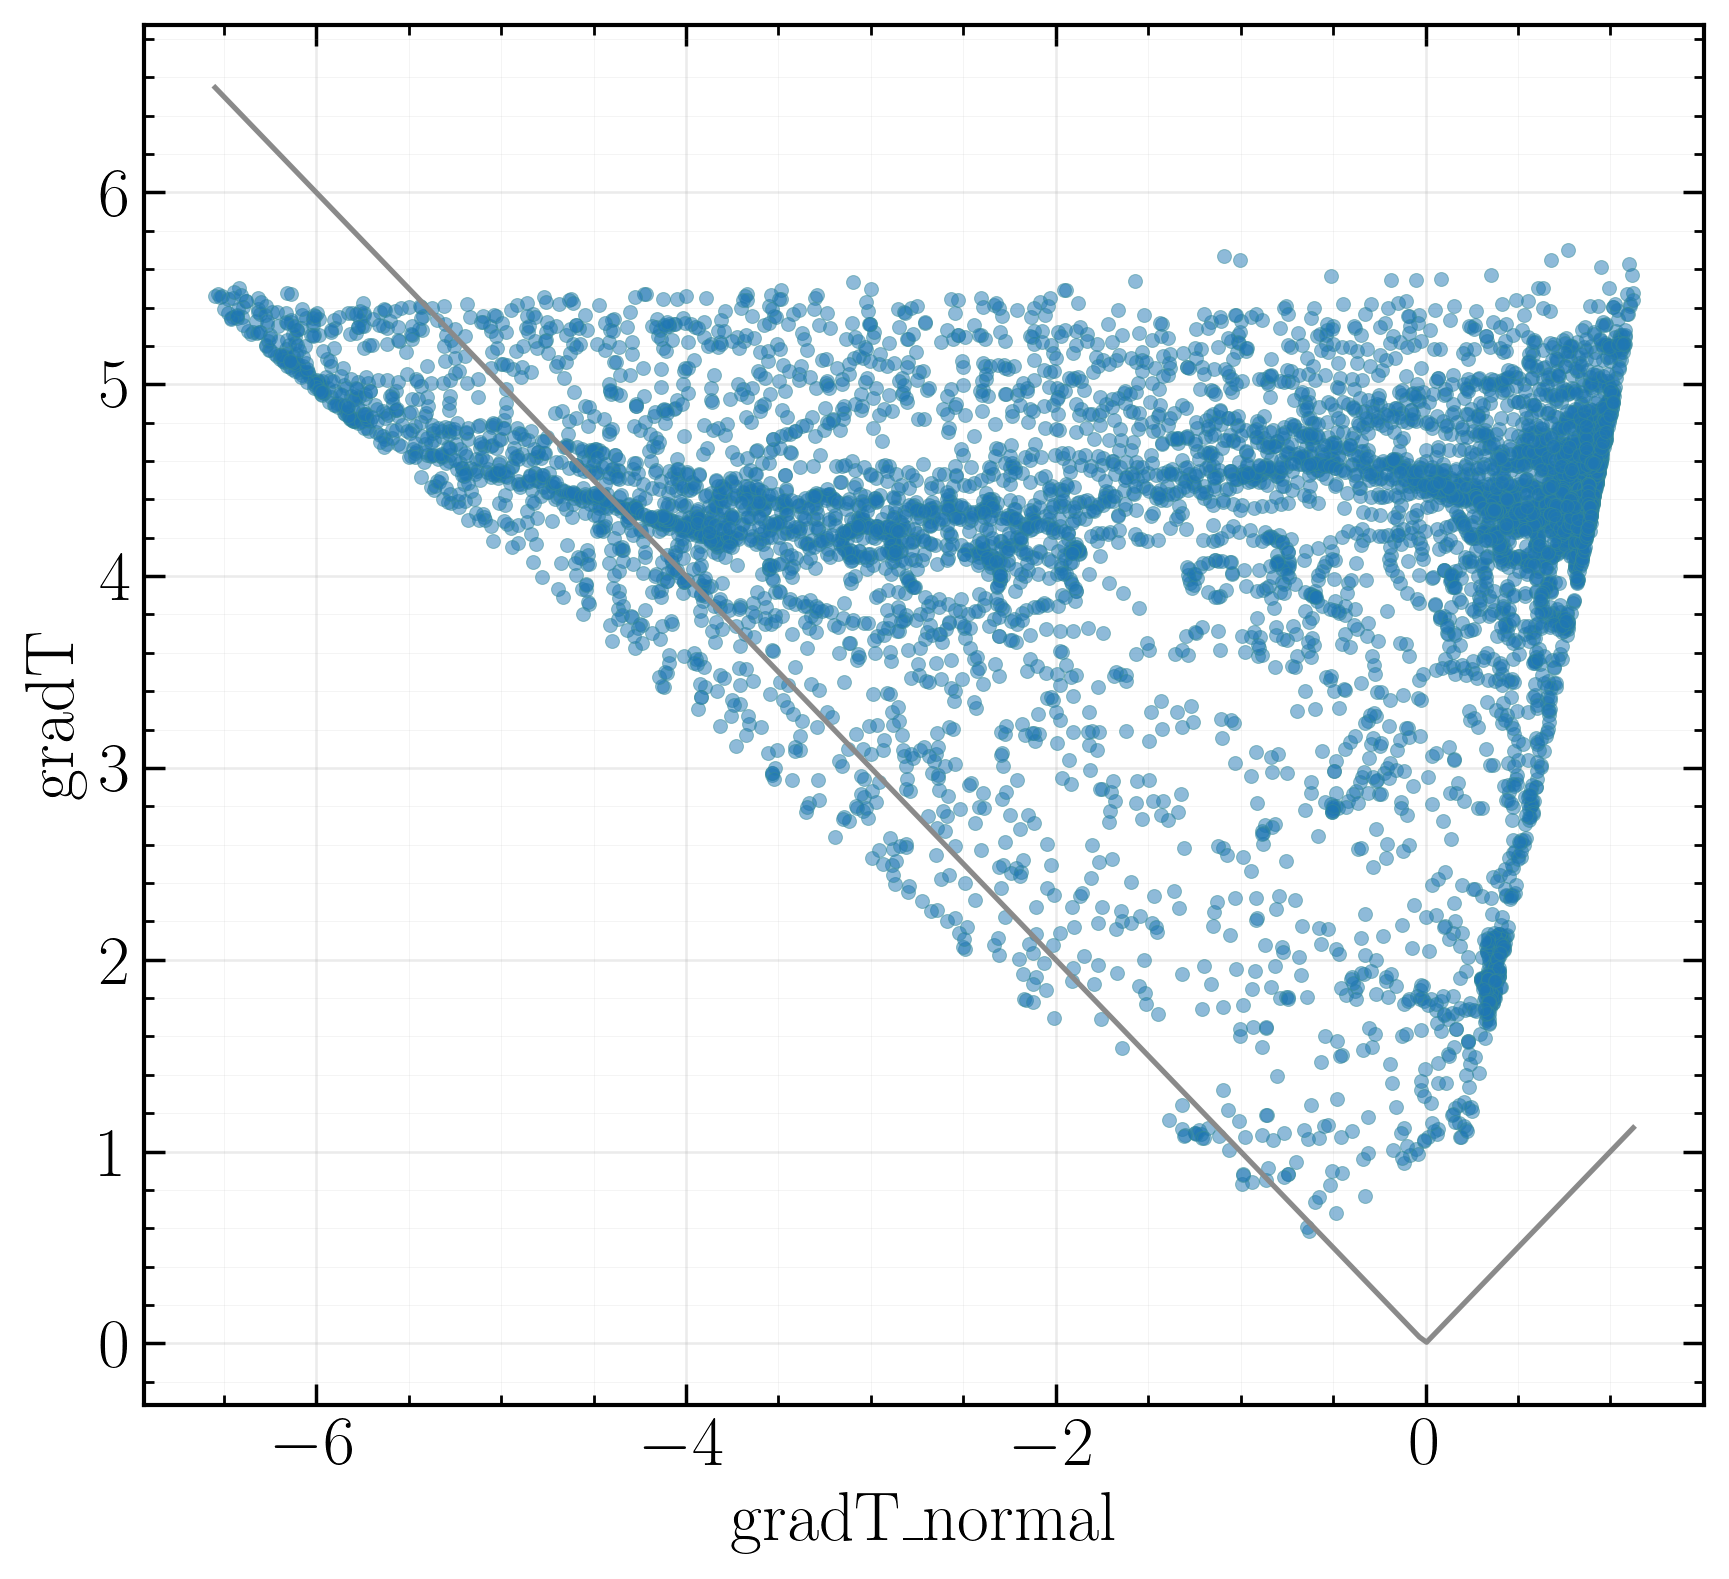

In [4]:
# gradT vs gradT_normal scatter
fig_grad, ax_grad = plt.subplots(figsize=FIG_SIZE, dpi=FIG_DPI, constrained_layout=True)
ax_grad.scatter(
    ratio_df[GRAD_T_NORMAL_COLUMN],
    ratio_df[GRAD_T_COLUMN],
    s=RATIO_SCATTER_S,
    alpha=RATIO_ALPHA,
    edgecolors=COLOR_DATA_EDGE,
    linewidths=0.3,
)
x_min = float(ratio_df[GRAD_T_NORMAL_COLUMN].min())
x_max = float(ratio_df[GRAD_T_NORMAL_COLUMN].max())
x_line = np.linspace(x_min, x_max, 200)
ax_grad.plot(
    x_line,
    np.abs(x_line),
    color=COLOR_LINE,
    linewidth=LINE_WIDTH,
)
ax_grad.set_xlabel(GRAD_T_NORMAL_COLUMN)
ax_grad.set_ylabel(GRAD_T_COLUMN)
style_axes(ax_grad)
plt.show()
plt.close(fig_grad)



In [5]:
# -----------------------------
# Compare |gradT| from dTdx/dTdy to gradT and gradT_normal
# -----------------------------
required_cols = ["dTdx", "dTdy", "gradT", "gradT_normal"]

if all(c in ratio_df.columns for c in required_cols):
    df_use = ratio_df
else:
    # Fallback: load fronts and extract needed columns
    frames = []
    for t in TIME_STEPS:
        case_t = make_case(time_step=t)
        fronts_t = load_fronts(case_t, PROGRESS_LEVELS)
        for c_val, front in fronts_t.items():
            require_columns(front, required_cols, context=f"t={t}, ISO {c_val}:")
            dfv = clean_valid_rows(front, required_cols)
            frames.append(dfv[required_cols])
    if not frames:
        raise RuntimeError("No valid rows found for gradT comparison.")
    df_use = pd.concat(frames, ignore_index=True)

gradT_from_derivs = np.sqrt(df_use["dTdx"]**2 + df_use["dTdy"]**2)
gradT_ref = df_use["gradT"]
gradT_normal_ref = df_use["gradT_normal"]

fig, axes = plt.subplots(1, 2, figsize=(11.0, 5.2), dpi=200, constrained_layout=True)

# gradT vs |gradT| from derivatives
axes[0].scatter(gradT_ref, gradT_from_derivs, s=6, alpha=0.5)
lo0 = float(min(gradT_ref.min(), gradT_from_derivs.min()))
hi0 = float(max(gradT_ref.max(), gradT_from_derivs.max()))
axes[0].plot([lo0, hi0], [lo0, hi0], linestyle="--", color="#7e7e7e", linewidth=1.2)
axes[0].set_xlabel("gradT (dataset)")
axes[0].set_ylabel("sqrt(dTdx^2 + dTdy^2)")
axes[0].set_title("gradT vs |gradT| from dTdx,dTdy")
axes[0].grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

# gradT_normal vs |gradT| from derivatives
axes[1].scatter(gradT_normal_ref, gradT_from_derivs, s=6, alpha=0.5)
lo1 = float(min(gradT_normal_ref.min(), gradT_from_derivs.min()))
hi1 = float(max(gradT_normal_ref.max(), gradT_from_derivs.max()))
axes[1].plot([lo1, hi1], [lo1, hi1], linestyle="--", color="#7e7e7e", linewidth=1.2)
axes[1].set_xlabel("gradT_normal (dataset)")
axes[1].set_ylabel("sqrt(dTdx^2 + dTdy^2)")
axes[1].set_title("gradT_normal vs |gradT| from dTdx,dTdy")
axes[1].grid(True, linestyle=":", linewidth=0.6, alpha=0.6)

plt.show()


RuntimeError: latex was not able to process the following string:
b'sqrt(dTdx^2 + dTdy^2)'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error file.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023/Debian) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./file.tex
LaTeX2e <2023-11-01> patch level 1
L3 programming layer <2024-01-22>
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2023/05/17 v1.4n Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/usr/share/texlive/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/share/texmf/tex/latex/cm-super/type1ec.sty
(/usr/share/texlive/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/share/texlive/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/share/texlive/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/share/texlive/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/share/texlive/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/share/texlive/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsmath.sty
For additional information on amsmath, use the `?' option.
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amstext.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsgen.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsbsy.sty)
(/usr/share/texlive/texmf-dist/tex/latex/amsmath/amsopn.sty))
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amssymb.sty
(/usr/share/texlive/texmf-dist/tex/latex/amsfonts/amsfonts.sty))
(/usr/share/texlive/texmf-dist/tex/latex/tools/bm.sty)
(/usr/share/texlive/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/share/texlive/texmf-dist/tex/latex/firstaid/underscore-ltx.sty)
(/usr/share/texlive/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/share/texlive/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file file.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.31 {\rmfamily sqrt(dTdx^
                          2 + dTdy^2)}%
No pages of output.
Transcript written on file.log.




<Figure size 2200x1040 with 2 Axes>

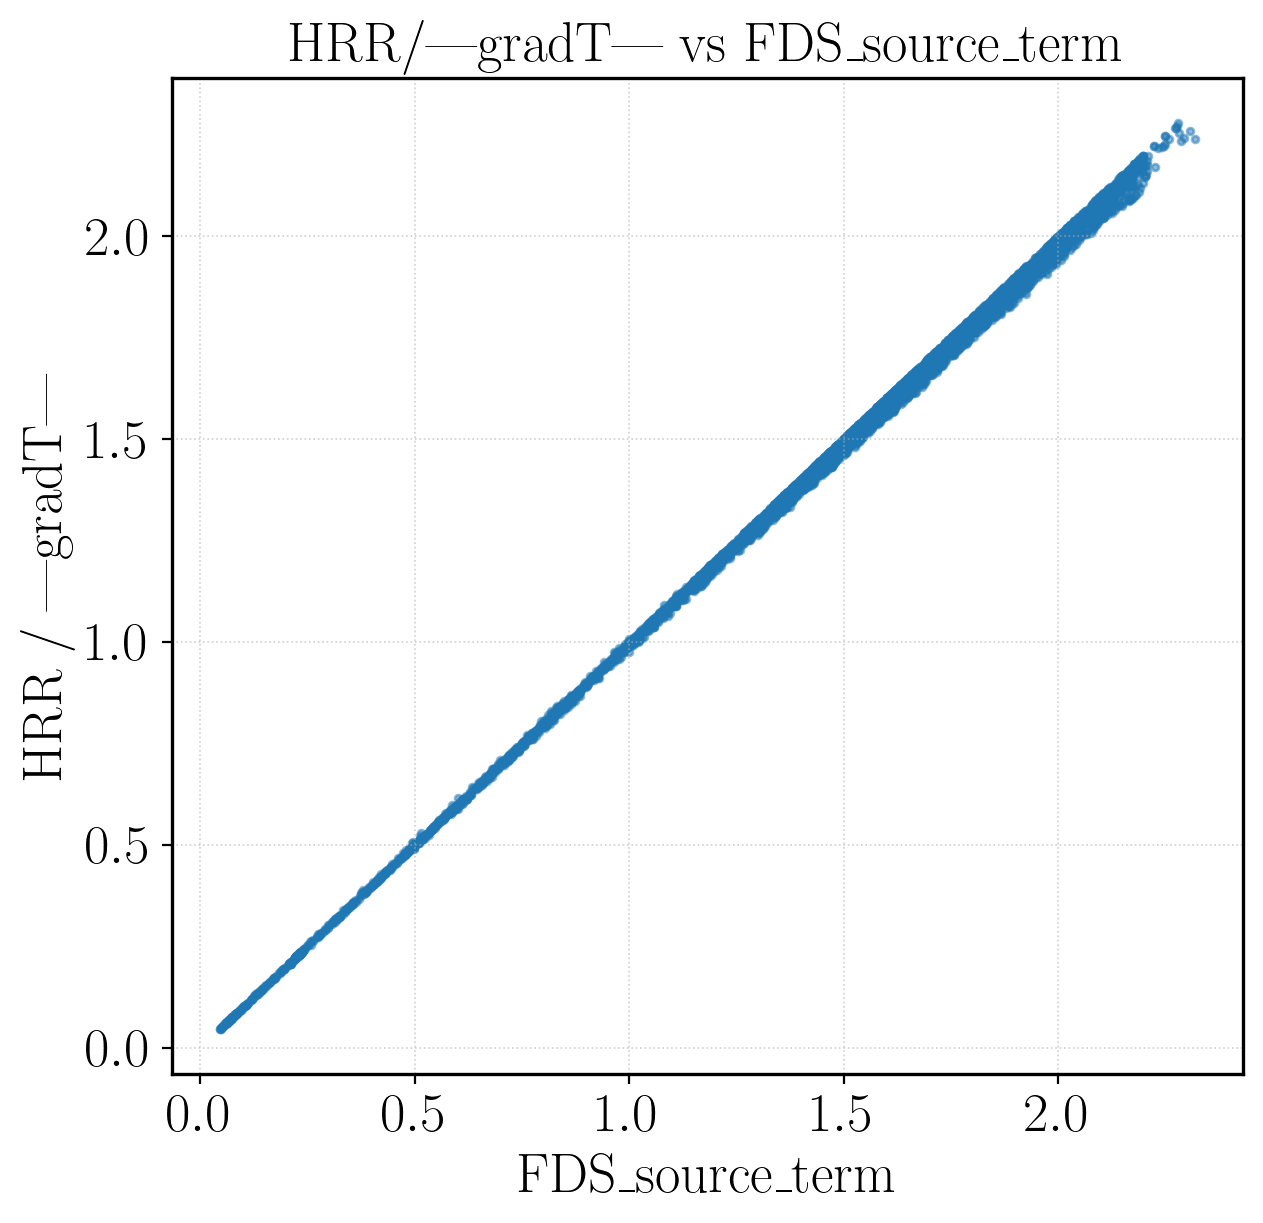

In [6]:
# -----------------------------
# Plot HRR/gradT vs FDS_source_term
# -----------------------------
required_cols = ["HRR", "gradT", "FDS_source_term"]

if all(c in ratio_df.columns for c in required_cols):
    df_use = ratio_df
else:
    frames = []
    for t in TIME_STEPS:
        case_t = make_case(time_step=t)
        fronts_t = load_fronts(case_t, PROGRESS_LEVELS)
        for c_val, front in fronts_t.items():
            require_columns(front, required_cols, context=f"t={t}, ISO {c_val}:")
            dfv = clean_valid_rows(front, required_cols)
            frames.append(dfv[required_cols])
    if not frames:
        raise RuntimeError("No valid rows found for HRR/gradT vs FDS_source_term plot.")
    df_use = pd.concat(frames, ignore_index=True)

ratio = df_use["HRR"] / (df_use["gradT"].abs() + 1e-30)

fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
ax.scatter(df_use["FDS_source_term"], ratio, s=6, alpha=0.5)
ax.set_xlabel("FDS_source_term")
ax.set_ylabel("HRR / |gradT|")
ax.set_title("HRR/|gradT| vs FDS_source_term")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()


Isocontour temperature: mean=940.34 K, std=0.00 K
cp_iso=1.298849e+03 J/kg/K, cp_ref=1.164192e+03 J/kg/K (at T_unburned=300.0 K)


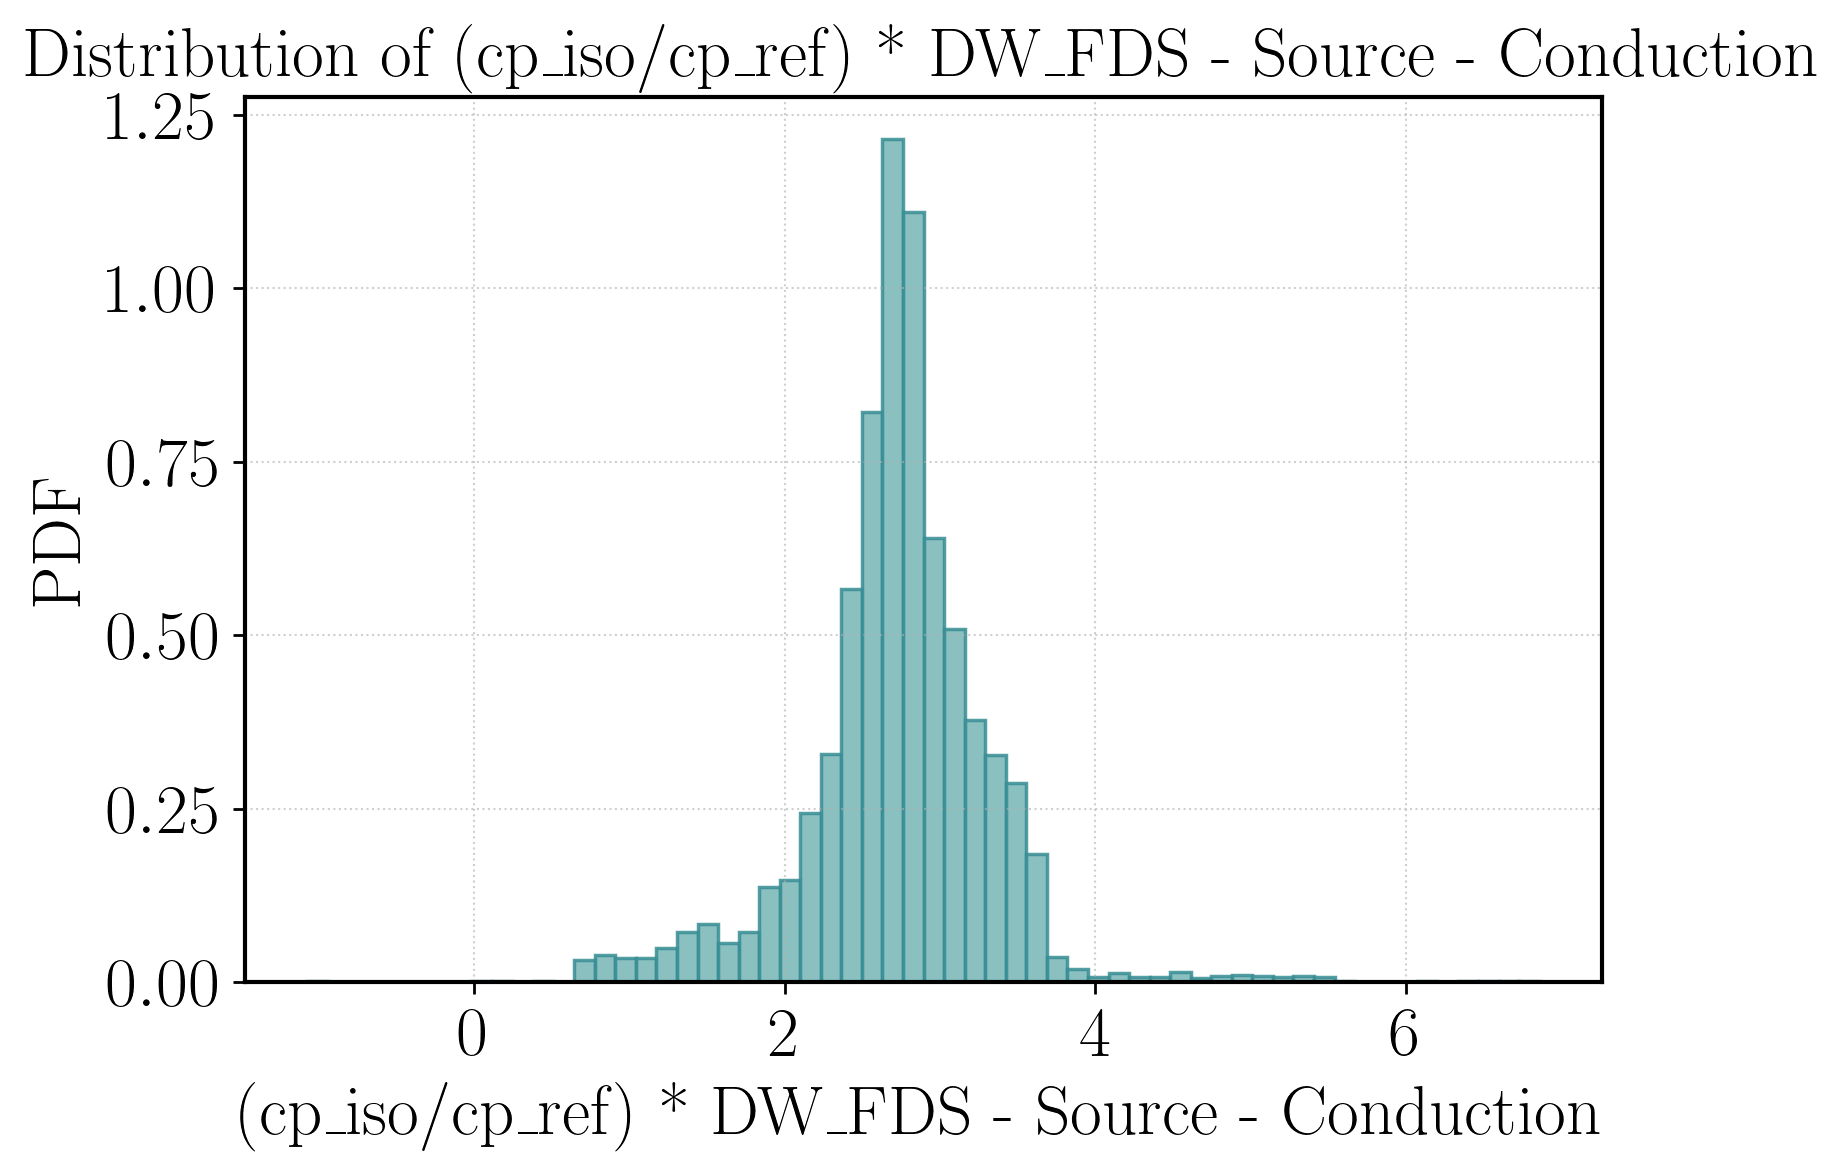

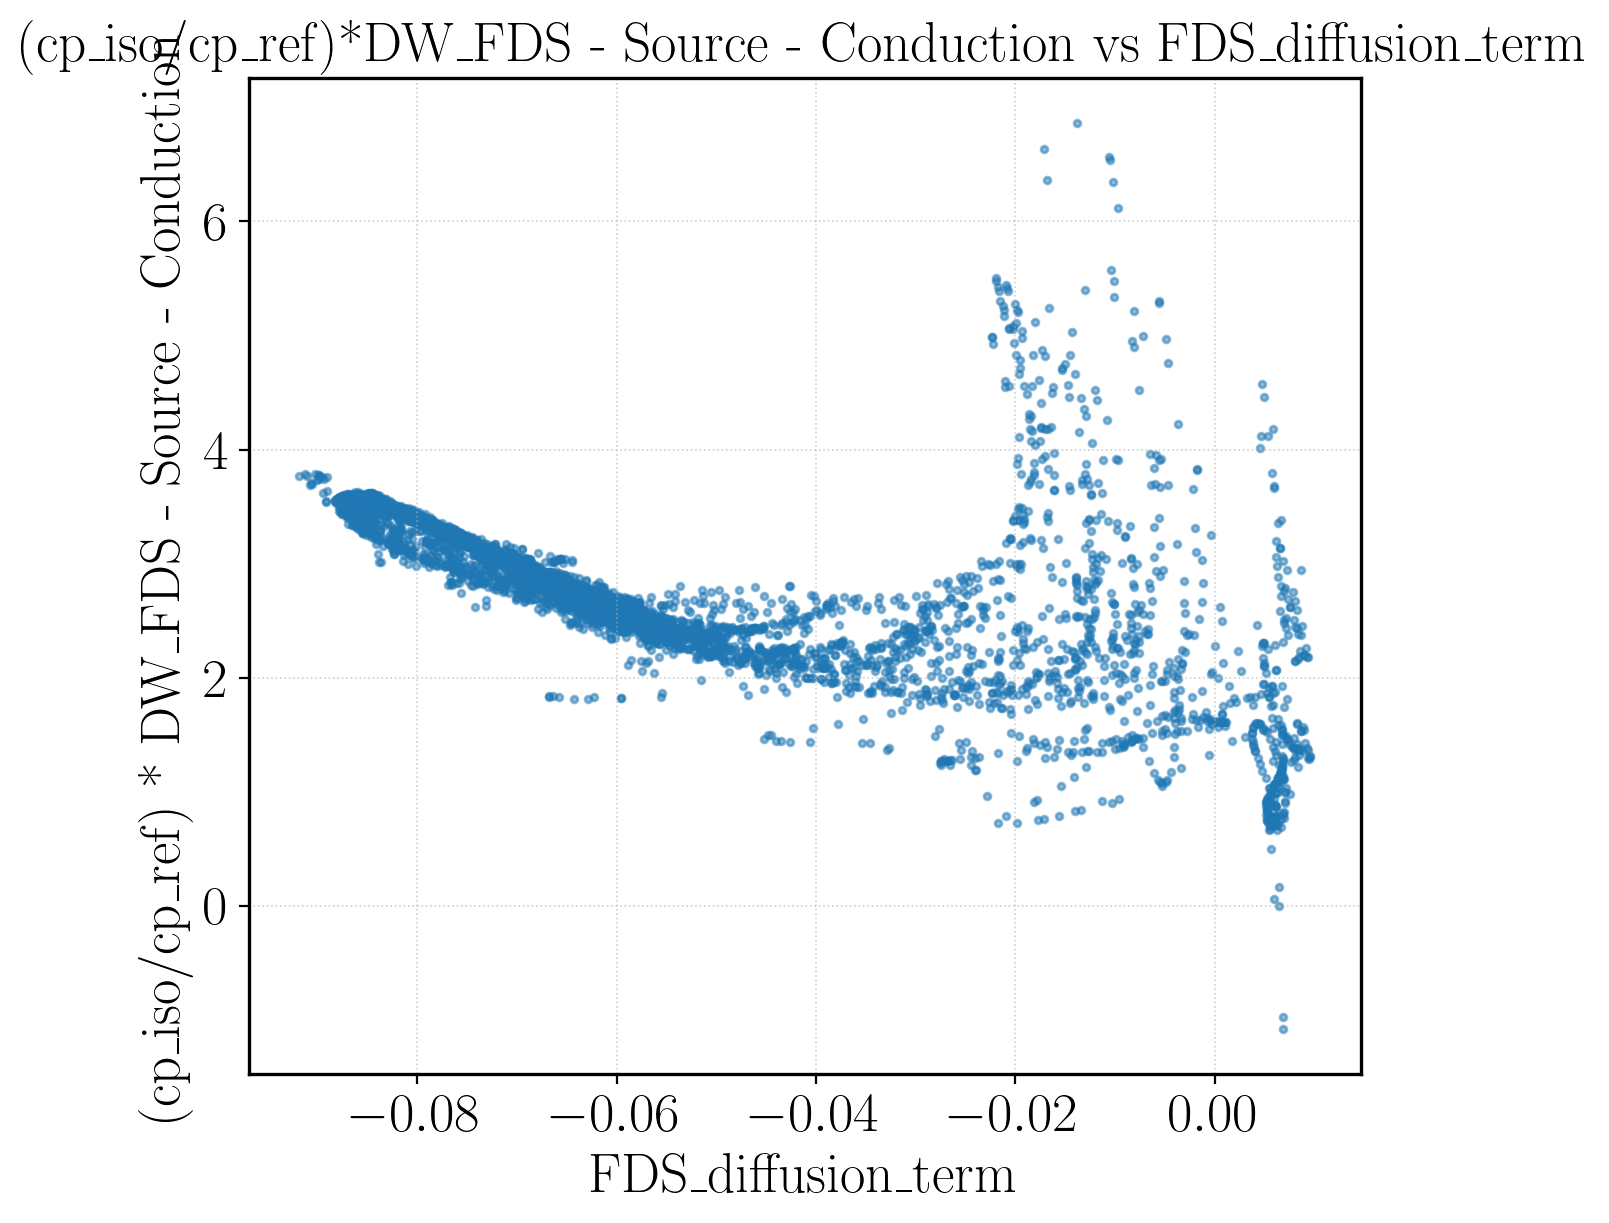

In [7]:
# -----------------------------
# Cantera (Burke) cp*rho_u*DW_FDS - FDS_source_term - FDS_conduction_term
# -----------------------------
import cantera as ct
from pathlib import Path

# Mechanism and mixture
mech_path = Path("FLAME/chemical_mech/BurkeH2.yaml")
if not mech_path.exists():
    raise FileNotFoundError(f"Mechanism file not found: {mech_path.resolve()}")

pressure = ct.one_atm
T_UNBURNED = 300.0  # K (adjust if your case uses a different unburned temperature)
fuel = "H2:1"
oxidizer = "O2:1, N2:3.76"

gas = ct.Solution(mech_path.as_posix())
gas.set_equivalence_ratio(PHI, fuel, oxidizer)

# Load fronts to get T, DW_FDS, density_ratio_sigma, FDS_source_term, FDS_conduction_term, FDS_diffusion_term
TARGET_COL = "DW_FDS"
SOURCE_CANDIDATES = ["FDS_source_term", "FDS_src_term"]
COND_CANDIDATES = ["FDS_conduction_term"]
DIFF_CANDIDATES = ["FDS_diffusion_term"]
T_COL = "T"

frames = []
SOURCE_COL = None
COND_COL = None
DIFF_COL = None
x_min = None
x_max = None
y_min = None
y_max = None

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)
    for c_val, front in fronts_t.items():
        if SOURCE_COL is None:
            SOURCE_COL = next((c for c in SOURCE_CANDIDATES if c in front.columns), None)
        if COND_COL is None:
            COND_COL = next((c for c in COND_CANDIDATES if c in front.columns), None)
        if DIFF_COL is None:
            DIFF_COL = next((c for c in DIFF_CANDIDATES if c in front.columns), None)
        if SOURCE_COL is None or COND_COL is None:
            raise ValueError("Missing FDS source/conduction columns in fronts.")
        required_cols = [T_COL, TARGET_COL, SOURCE_COL, COND_COL, DIFF_COL, DENSITY_COLUMN]
        require_columns(front, required_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, required_cols)
        frames.append(dfv[required_cols])
        if "x" in front.columns:
            x_min = float(front["x"].min()) if x_min is None else min(x_min, float(front["x"].min()))
            x_max = float(front["x"].max()) if x_max is None else max(x_max, float(front["x"].max()))
        if "y" in front.columns:
            y_min = float(front["y"].min()) if y_min is None else min(y_min, float(front["y"].min()))
            y_max = float(front["y"].max()) if y_max is None else max(y_max, float(front["y"].max()))

if not frames:
    raise RuntimeError("No valid rows found for cp ratio comparison.")

df_all = pd.concat(frames, ignore_index=True)


# Temperature at the isocontour (use mean; should be narrow if truly an isotherm)
T_scaled = df_all[T_COL] * T_UNBURNED
T_iso = float(T_scaled.mean())
T_std = float(T_scaled.std())
print(f"Isocontour temperature: mean={T_iso:.2f} K, std={T_std:.2f} K")

# Ensure mixture composition is set (done already above, but safe to keep explicit)
gas.set_equivalence_ratio(PHI, fuel, oxidizer)

# cp at the isotherm level
gas.TP = T_iso, pressure
cp_iso = float(gas.cp_mass)

# cp_ref at unburned level (same mixture, unburned temperature)
gas.TP = T_UNBURNED, pressure
cp_ref = float(gas.cp_mass)

print(f"cp_iso={cp_iso:.6e} J/kg/K, cp_ref={cp_ref:.6e} J/kg/K (at T_unburned={T_UNBURNED:.1f} K)")

# Your comparison term
term = (cp_iso / cp_ref) * df_all[DENSITY_COLUMN]* df_all[TARGET_COL] - df_all[SOURCE_COL] - df_all[COND_COL]


fig, ax = plt.subplots(figsize=(7.0, 4.6), dpi=FIG_DPI)
ax.hist(term, bins=60, density=True, color=COLOR_DATA, edgecolor=COLOR_DATA_EDGE, alpha=0.85)
ax.set_xlabel("(cp_iso/cp_ref) * DW_FDS - Source - Conduction")
ax.set_ylabel("PDF")
ax.set_title("Distribution of (cp_iso/cp_ref) * DW_FDS - Source - Conduction")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

# Scatter vs FDS_diffusion_term
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
ax.scatter(df_all[DIFF_COL], term, s=6, alpha=0.5)
ax.set_xlabel("FDS_diffusion_term")
ax.set_ylabel("(cp_iso/cp_ref) * DW_FDS - Source - Conduction")
ax.set_title("(cp_iso/cp_ref)*DW_FDS - Source - Conduction vs FDS_diffusion_term")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()


Isocontour temperature: mean=940.34 K, std=0.00 K
Thermal conductivity: lambda_u=3.9878e-02, lambda_iso=9.5459e-02, lambda_tilde=2.393762


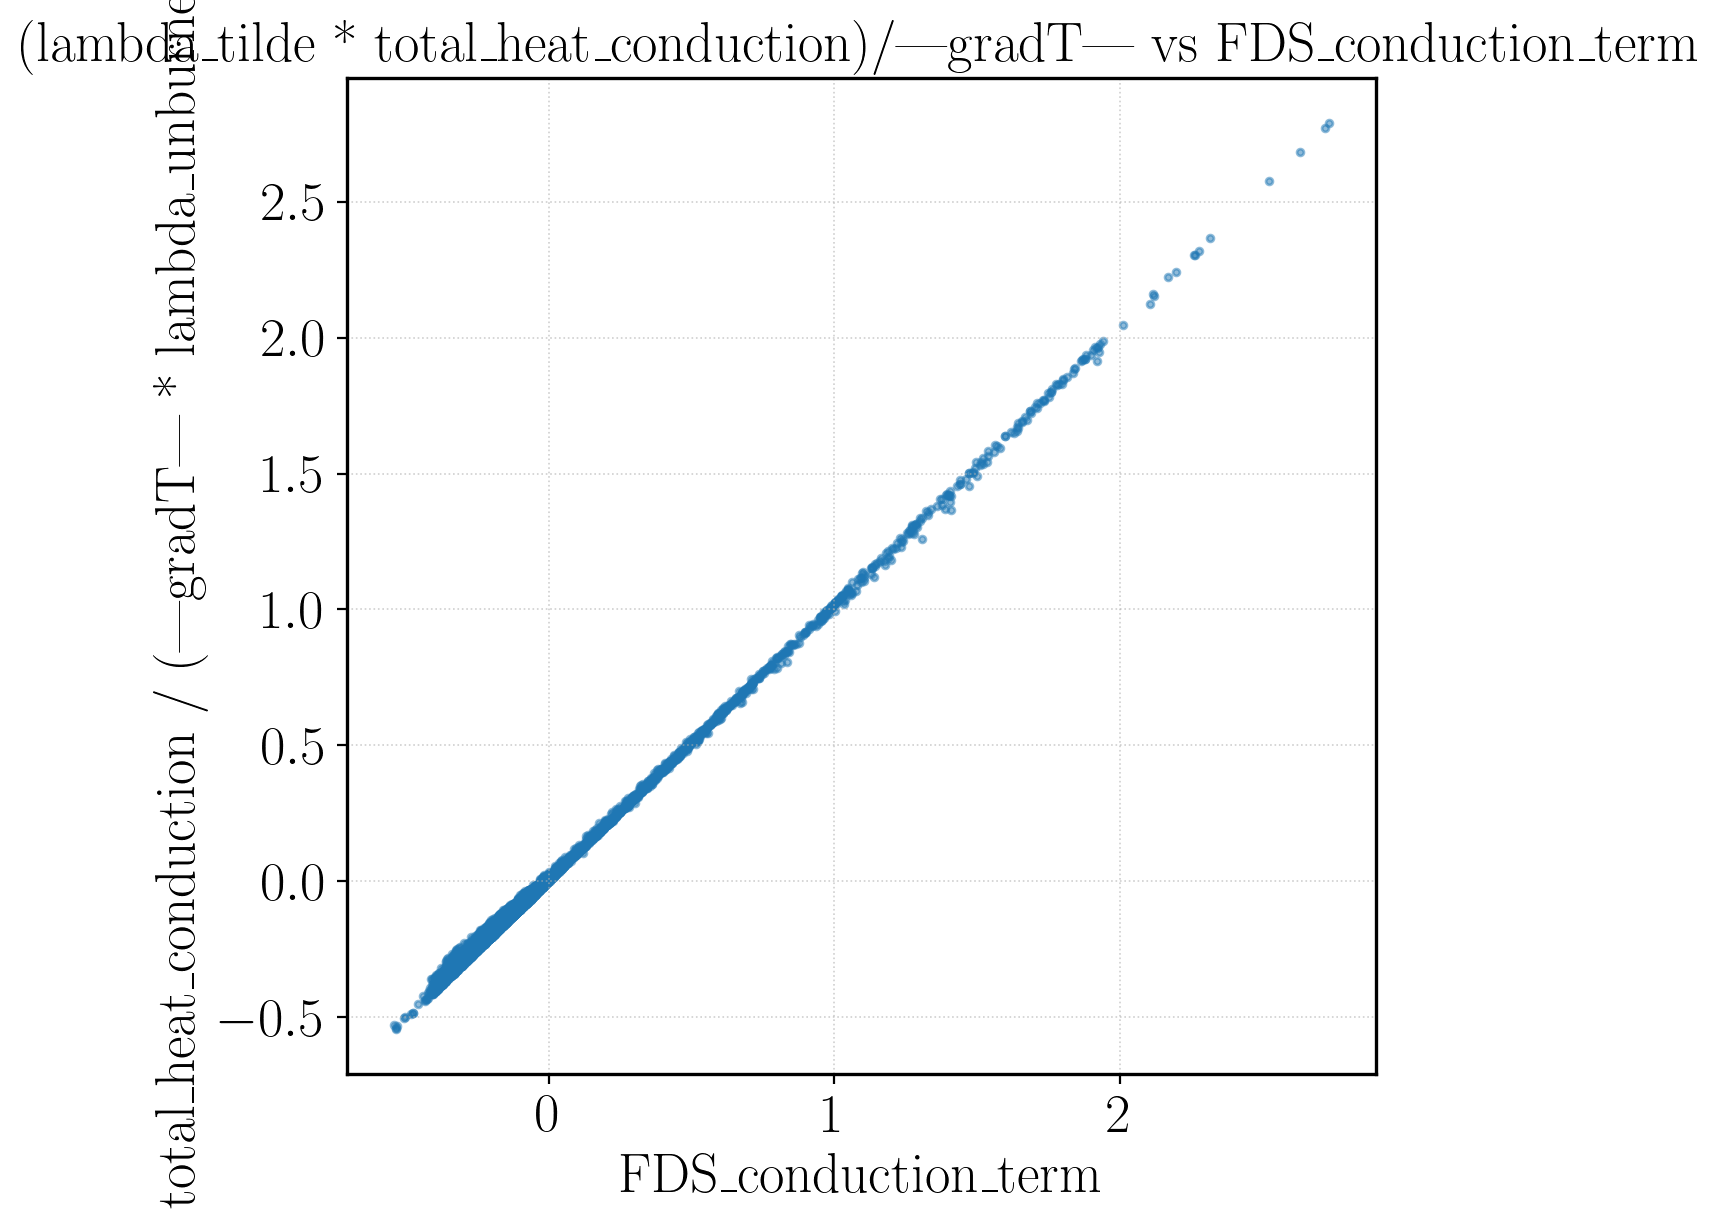

Ratio of (total_heat_conduction) / |gradT| to FDS_conduction_term:
1.0851684


In [8]:
# -----------------------------
# Plot (lambda_tilde * total_heat_conduction)/gradT vs FDS_conduction_term
# -----------------------------
import cantera as ct
from pathlib import Path

required_cols = ["total_heat_conduction", "gradT", "FDS_conduction_term", "T"]

if all(c in ratio_df.columns for c in required_cols):
    df_use = ratio_df
else:
    frames = []
    for t in TIME_STEPS:
        case_t = make_case(time_step=t)
        fronts_t = load_fronts(case_t, PROGRESS_LEVELS)
        for c_val, front in fronts_t.items():
            require_columns(front, required_cols, context=f"t={t}, ISO {c_val}:")
            dfv = clean_valid_rows(front, required_cols)
            frames.append(dfv[required_cols])
    if not frames:
        raise RuntimeError("No valid rows found for total_heat_conduction/gradT plot.")
    df_use = pd.concat(frames, ignore_index=True)

# Thermal conductivity at the isocontour temperature (mean) for unburned mixture
mech_path = Path("FLAME/chemical_mech/BurkeH2.yaml")
if not mech_path.exists():
    raise FileNotFoundError(f"Mechanism file not found: {mech_path.resolve()}")
pressure = ct.one_atm
fuel = "H2:1"
oxidizer = "O2:1, N2:3.76"

T_scaled = df_use["T"] * T_UNBURNED
T_iso = float(T_scaled.mean())
T_std = float(T_scaled.std())
print(f"Isocontour temperature: mean={T_iso:.2f} K, std={T_std:.2f} K")

gas = ct.Solution(mech_path.as_posix())
gas.set_equivalence_ratio(PHI, fuel, oxidizer)

gas.TP = T_UNBURNED, pressure
lambda_unburned = gas.thermal_conductivity

gas.TP = T_iso, pressure
lambda_iso = gas.thermal_conductivity
lambda_tilde = lambda_iso / lambda_unburned
print(f"Thermal conductivity: lambda_u={lambda_unburned:.4e}, lambda_iso={lambda_iso:.4e}, lambda_tilde={lambda_tilde:.6f}")

ratio = (df_use["total_heat_conduction"] ) / (df_use["gradT"].abs() + 1e-30) / lambda_unburned / 100

fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
ax.scatter(df_use["FDS_conduction_term"], ratio, s=6, alpha=0.5)
ax.set_xlabel("FDS_conduction_term")
ax.set_ylabel("total_heat_conduction / (|gradT| * lambda_unburned)")
ax.set_title("(lambda_tilde * total_heat_conduction)/|gradT| vs FDS_conduction_term")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()
#Print ratio of lambda_tilde * total_heat_conduction / |gradT| / FDS_conduction_term
print("Ratio of (total_heat_conduction) / |gradT| to FDS_conduction_term:")
print(np.average(ratio / (df_use["FDS_conduction_term"] + 1e-30)))

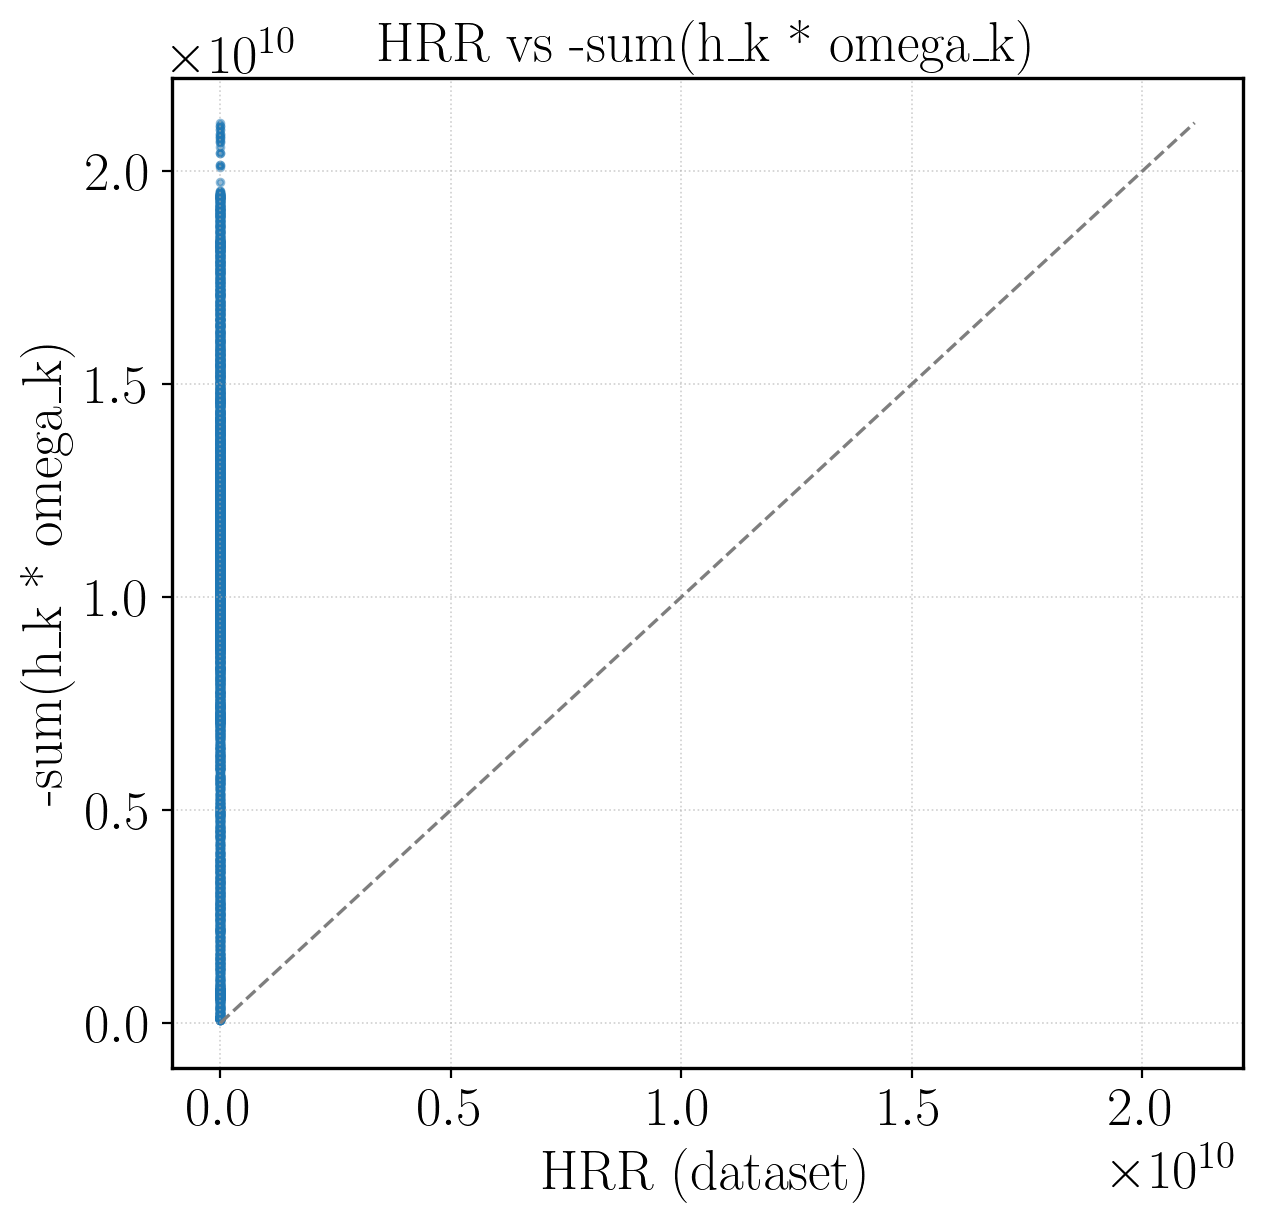

In [9]:
# -----------------------------
# Compare HRR to -sum(h_k * omega_k)
# -----------------------------
import cantera as ct
from pathlib import Path

mech_path = Path("FLAME/chemical_mech/BurkeH2.yaml")
if not mech_path.exists():
    raise FileNotFoundError(f"Mechanism file not found: {mech_path.resolve()}")

pressure = ct.one_atm
gas = ct.Solution(mech_path.as_posix())
gas.set_equivalence_ratio(PHI, "H2:1", "O2:1, N2:3.76")

# Collect required columns from fronts
frames = []
omega_cols = None
HRR_COL = None
T_COL = "T"

for t in TIME_STEPS:
    case_t = make_case(time_step=t)
    fronts_t = load_fronts(case_t, PROGRESS_LEVELS)
    for c_val, front in fronts_t.items():
        if HRR_COL is None:
            HRR_COL = next((c for c in ["HRR", "hrr"] if c in front.columns), None)
        if omega_cols is None:
            omega_cols = [c for c in front.columns if c.startswith("omega_")]
        if HRR_COL is None or not omega_cols:
            raise ValueError("Missing HRR or omega_* columns in fronts.")
        required_cols = [T_COL, HRR_COL] + omega_cols
        require_columns(front, required_cols, context=f"t={t}, ISO {c_val}:")
        dfv = clean_valid_rows(front, required_cols)
        frames.append(dfv[required_cols])

if not frames:
    raise RuntimeError("No valid rows found for HRR comparison.")

df_all = pd.concat(frames, ignore_index=True)

# Optional downsampling for speed
MAX_SAMPLES = 20000
if len(df_all) > MAX_SAMPLES:
    df_all = df_all.sample(MAX_SAMPLES, random_state=0).reset_index(drop=True)

# Map omega_* columns to species indices
species_names = [c.replace("omega_", "") for c in omega_cols]
keep = []
indices = []
for col, sp in zip(omega_cols, species_names):
    if sp in gas.species_names:
        keep.append(col)
        indices.append(gas.species_index(sp))

if not keep:
    raise RuntimeError("No omega_* columns match mechanism species.")

omega_cols = keep
omega_mat = df_all[omega_cols].to_numpy()
T_vals = df_all[T_COL].to_numpy()

# h_k depends only on T for ideal gas; compute per-sample
h_vals = np.empty((len(T_vals), len(indices)))
for i, T in enumerate(T_vals):
    gas.TP = float(T), pressure
    h_vals[i, :] = gas.partial_molar_enthalpies[indices]  # J/kmol

# If omega_* is in kg/m^3/s, switch to mass basis
OMEGA_BASIS = "kmol"  # change to "kg" if needed
if OMEGA_BASIS == "kg":
    mw = gas.molecular_weights[indices]
    h_vals = h_vals / mw  # J/kg

hrr_from_omega = -np.sum(h_vals * omega_mat, axis=1)
hrr_ref = df_all[HRR_COL].to_numpy()

fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
ax.scatter(hrr_ref, hrr_from_omega, s=6, alpha=0.5)
lo = float(min(hrr_ref.min(), hrr_from_omega.min()))
hi = float(max(hrr_ref.max(), hrr_from_omega.max()))
ax.plot([lo, hi], [lo, hi], linestyle="--", color="#7e7e7e", linewidth=1.2)
ax.set_xlabel(f"{HRR_COL} (dataset)")
ax.set_ylabel("-sum(h_k * omega_k)")
ax.set_title("HRR vs -sum(h_k * omega_k)")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()


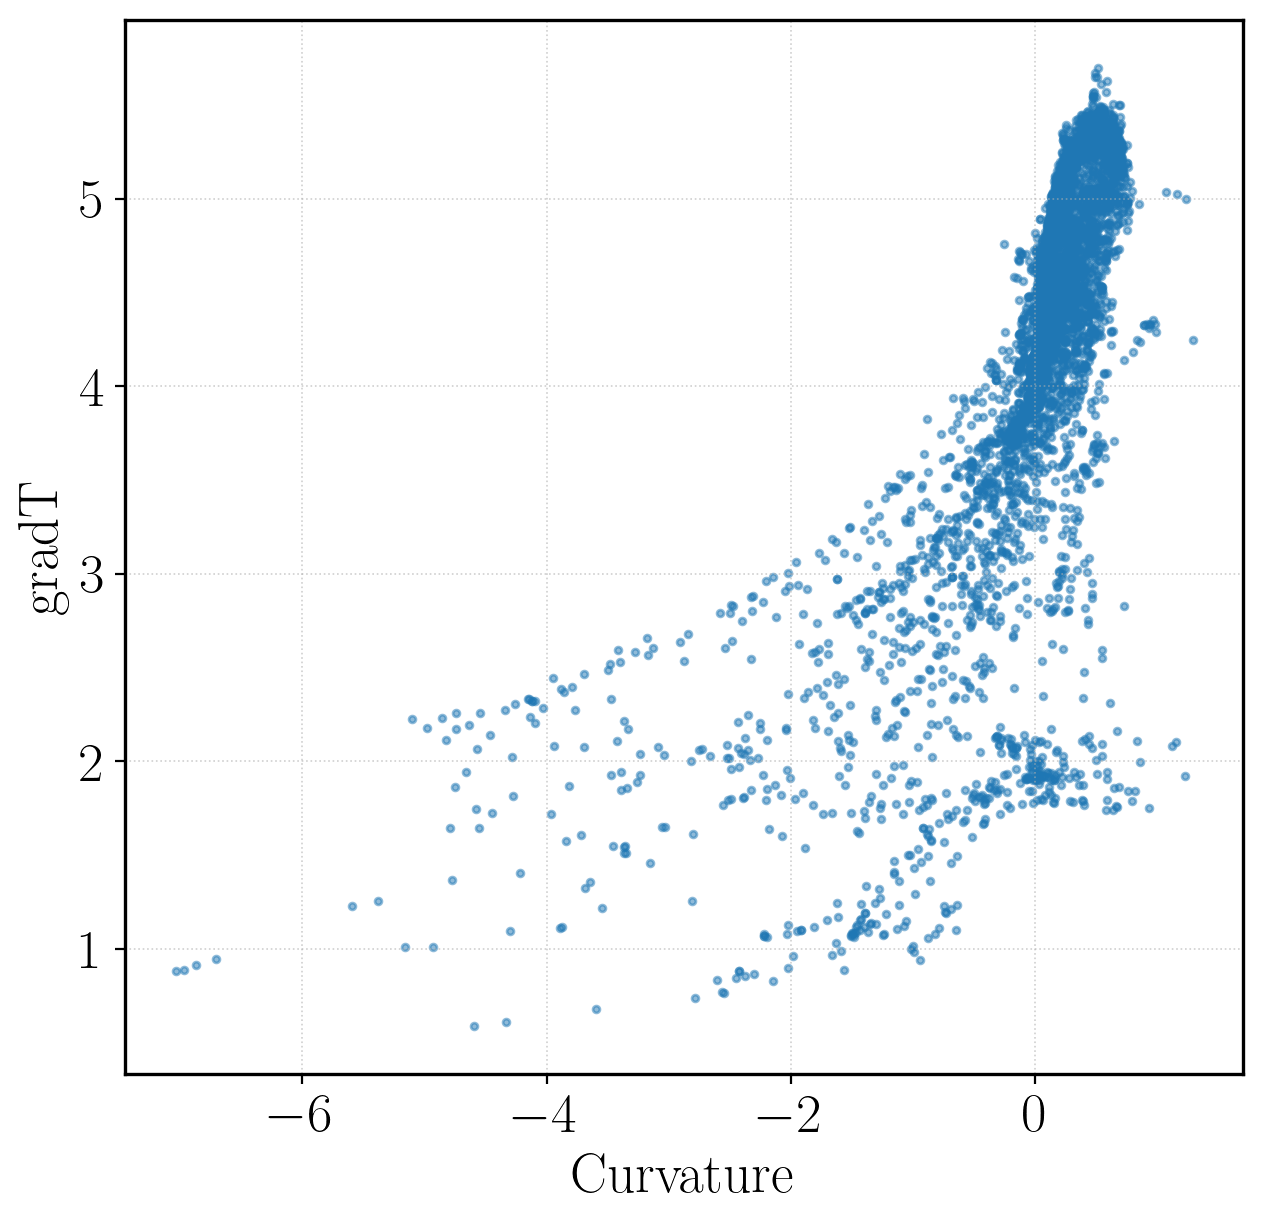

In [10]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[CURVATURE_COLUMN], dfv[GRAD_T_COLUMN], s=6, alpha=0.5)
ax.set_xlabel("Curvature")
ax.set_ylabel("gradT")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

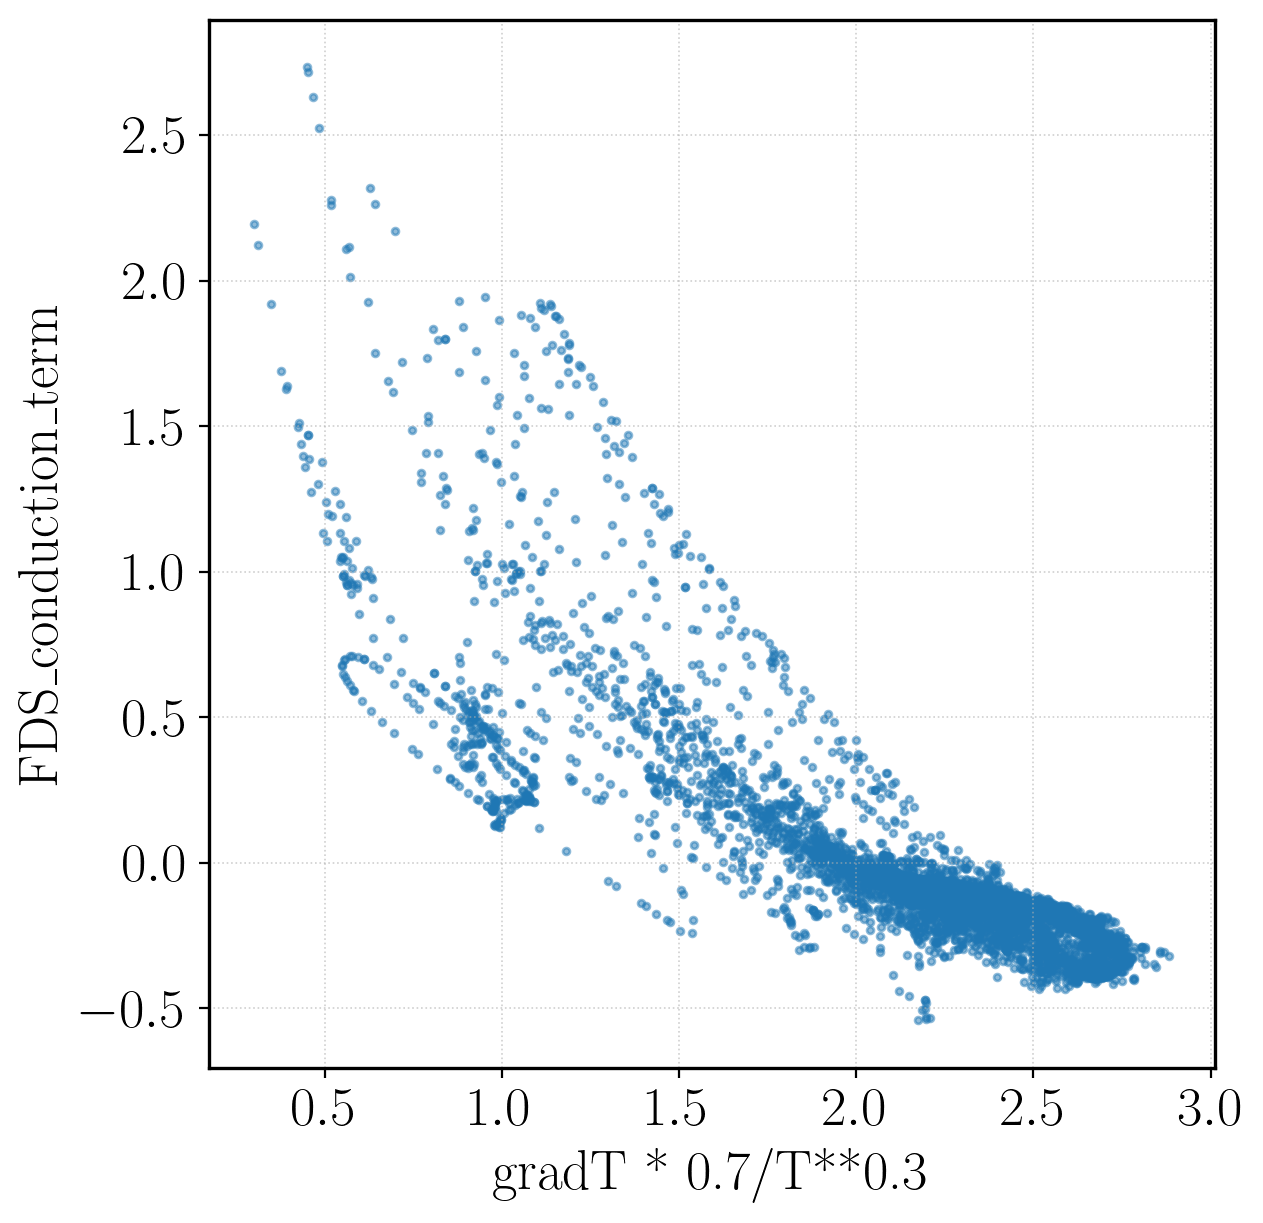

In [17]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter( 0.7/(dfv[DENSITY_COLUMN])**0.3 * dfv[GRAD_T_COLUMN], dfv["FDS_conduction_term"],s=6, alpha=0.5)
ax.set_ylabel("FDS_conduction_term")
ax.set_xlabel("gradT * 0.7/T**0.3")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

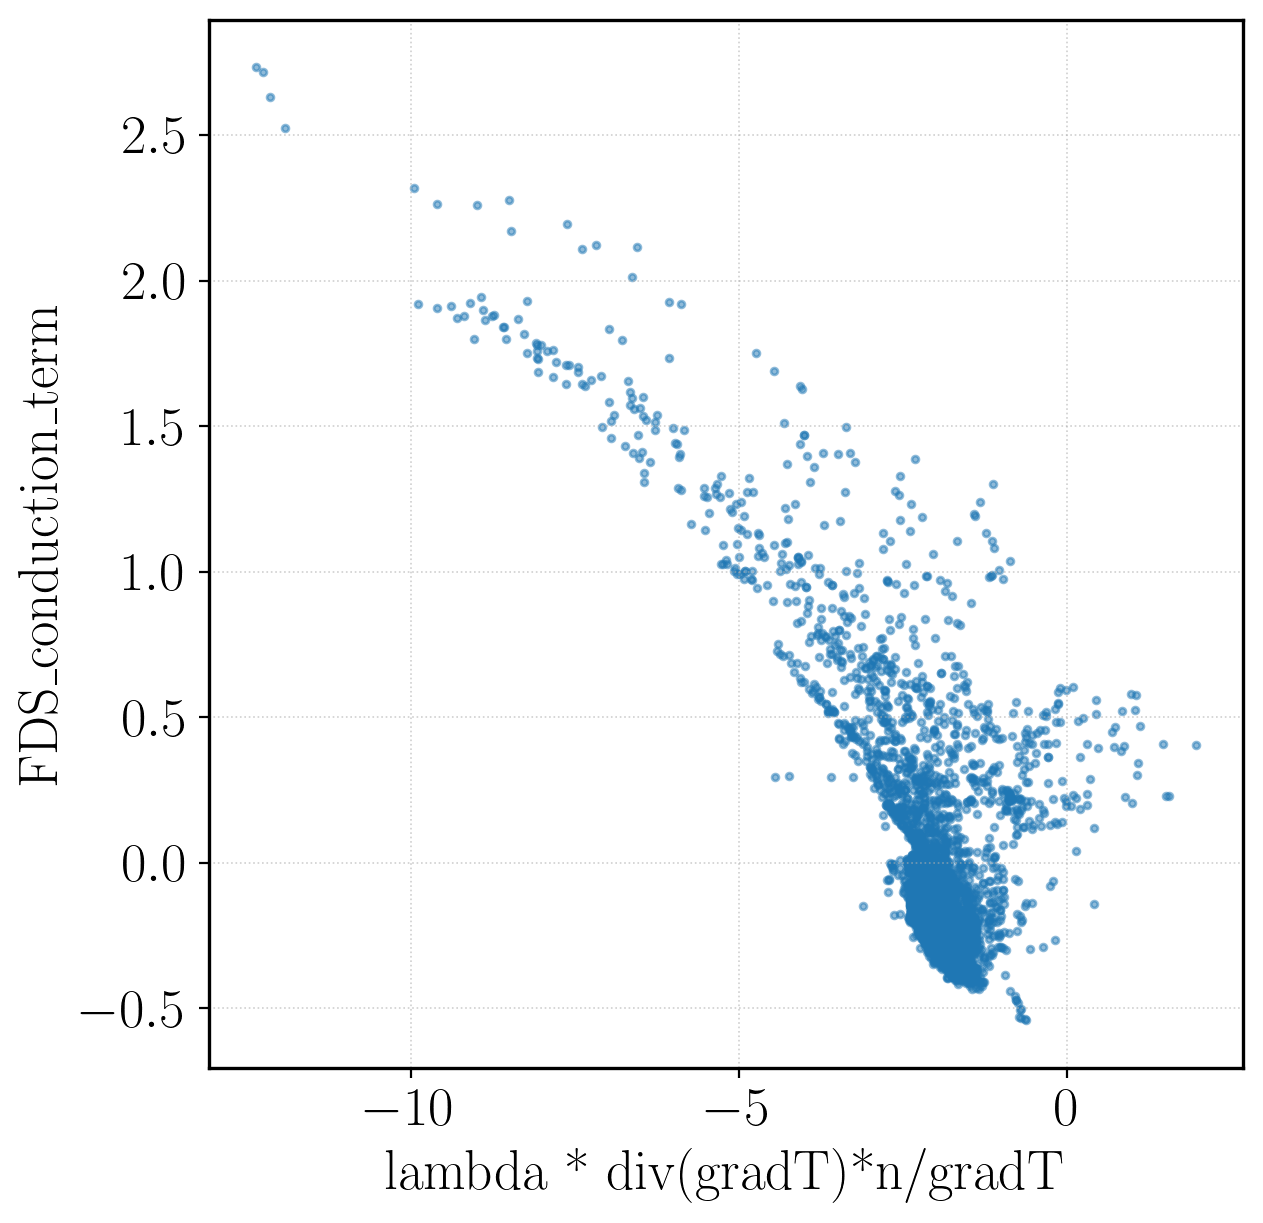

In [28]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter( dfv["FDS_conduction_term"]-0.7/(dfv[DENSITY_COLUMN])**0.3 * dfv[GRAD_T_COLUMN] + dfv[CURVATURE_COLUMN] * (dfv[DENSITY_COLUMN])**0.7, dfv["FDS_conduction_term"], s=6, alpha=0.5)
ax.set_ylabel("FDS_conduction_term")
ax.set_xlabel("lambda * div(gradT)*n/gradT")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

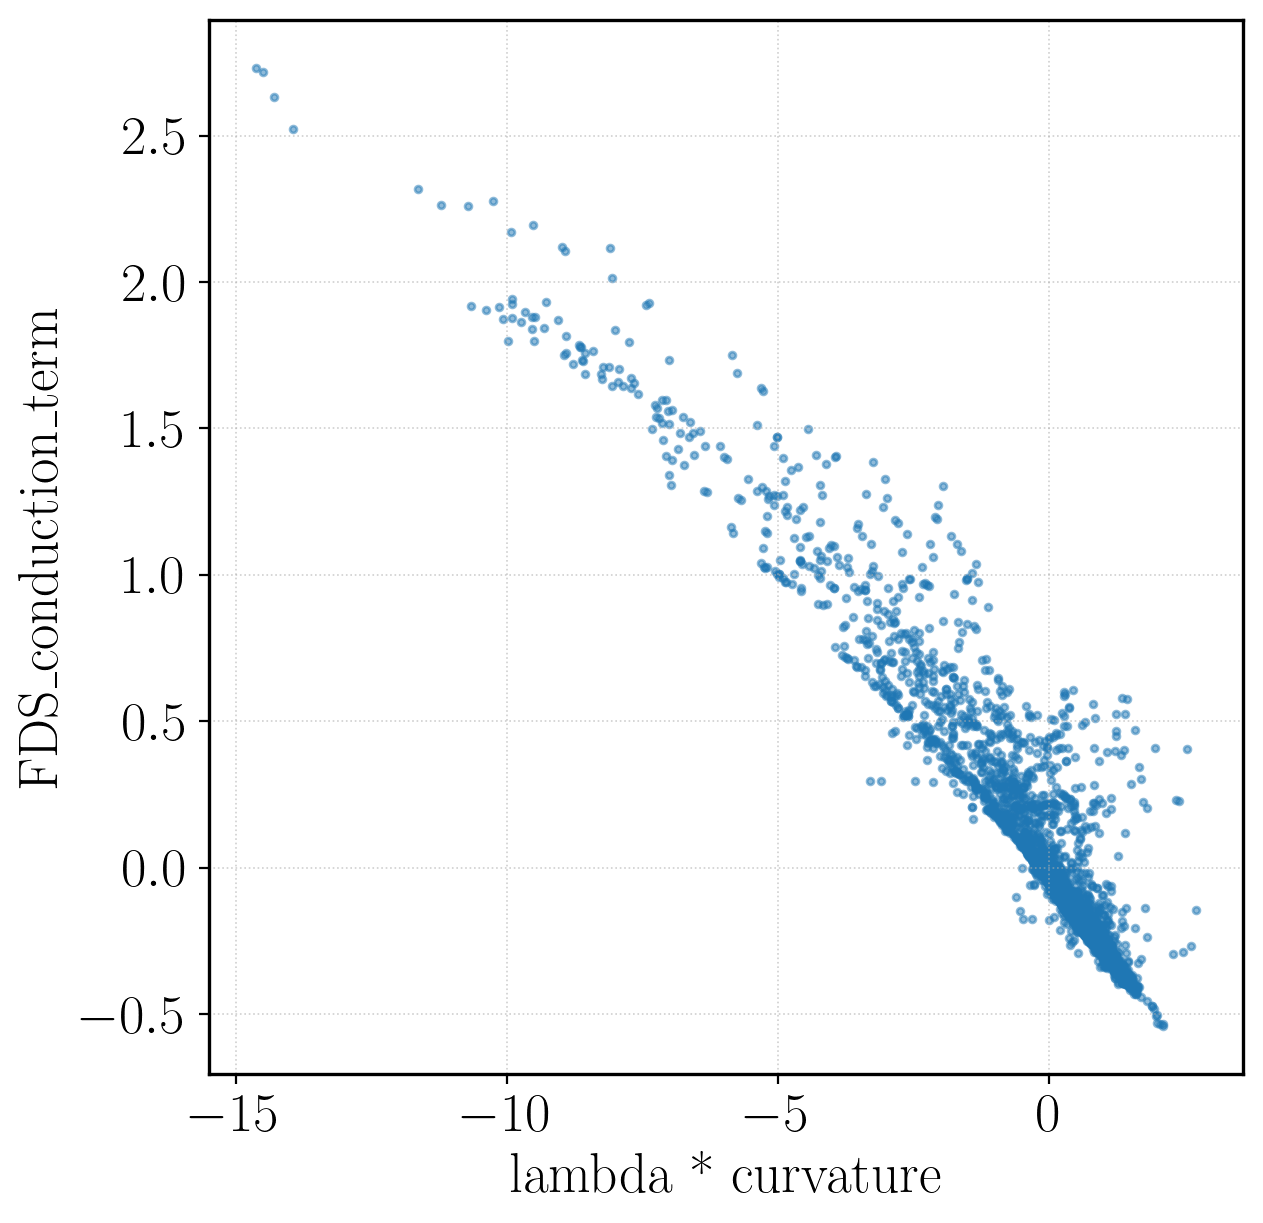

In [16]:

fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[CURVATURE_COLUMN] * (dfv[DENSITY_COLUMN])**0.7,dfv["FDS_conduction_term"], s=6, alpha=0.5)
ax.set_ylabel("FDS_conduction_term")
ax.set_xlabel("lambda * curvature")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

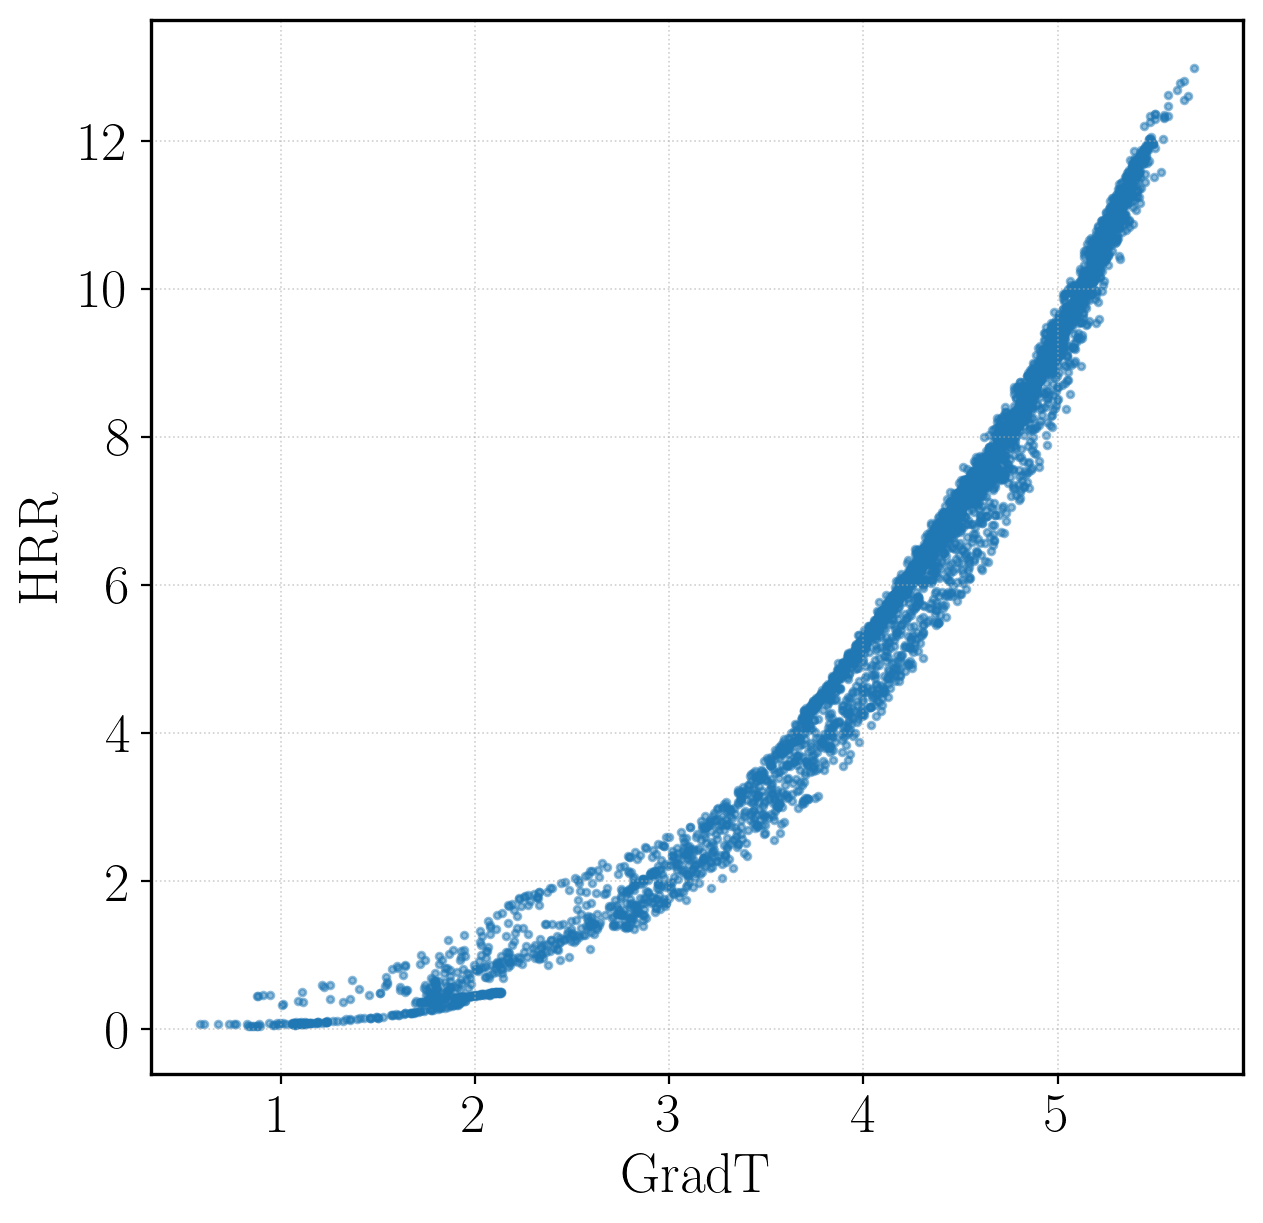

In [18]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[GRAD_T_COLUMN] ,dfv[HRR_COL], s=6, alpha=0.5)
ax.set_ylabel("HRR")
ax.set_xlabel("GradT")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

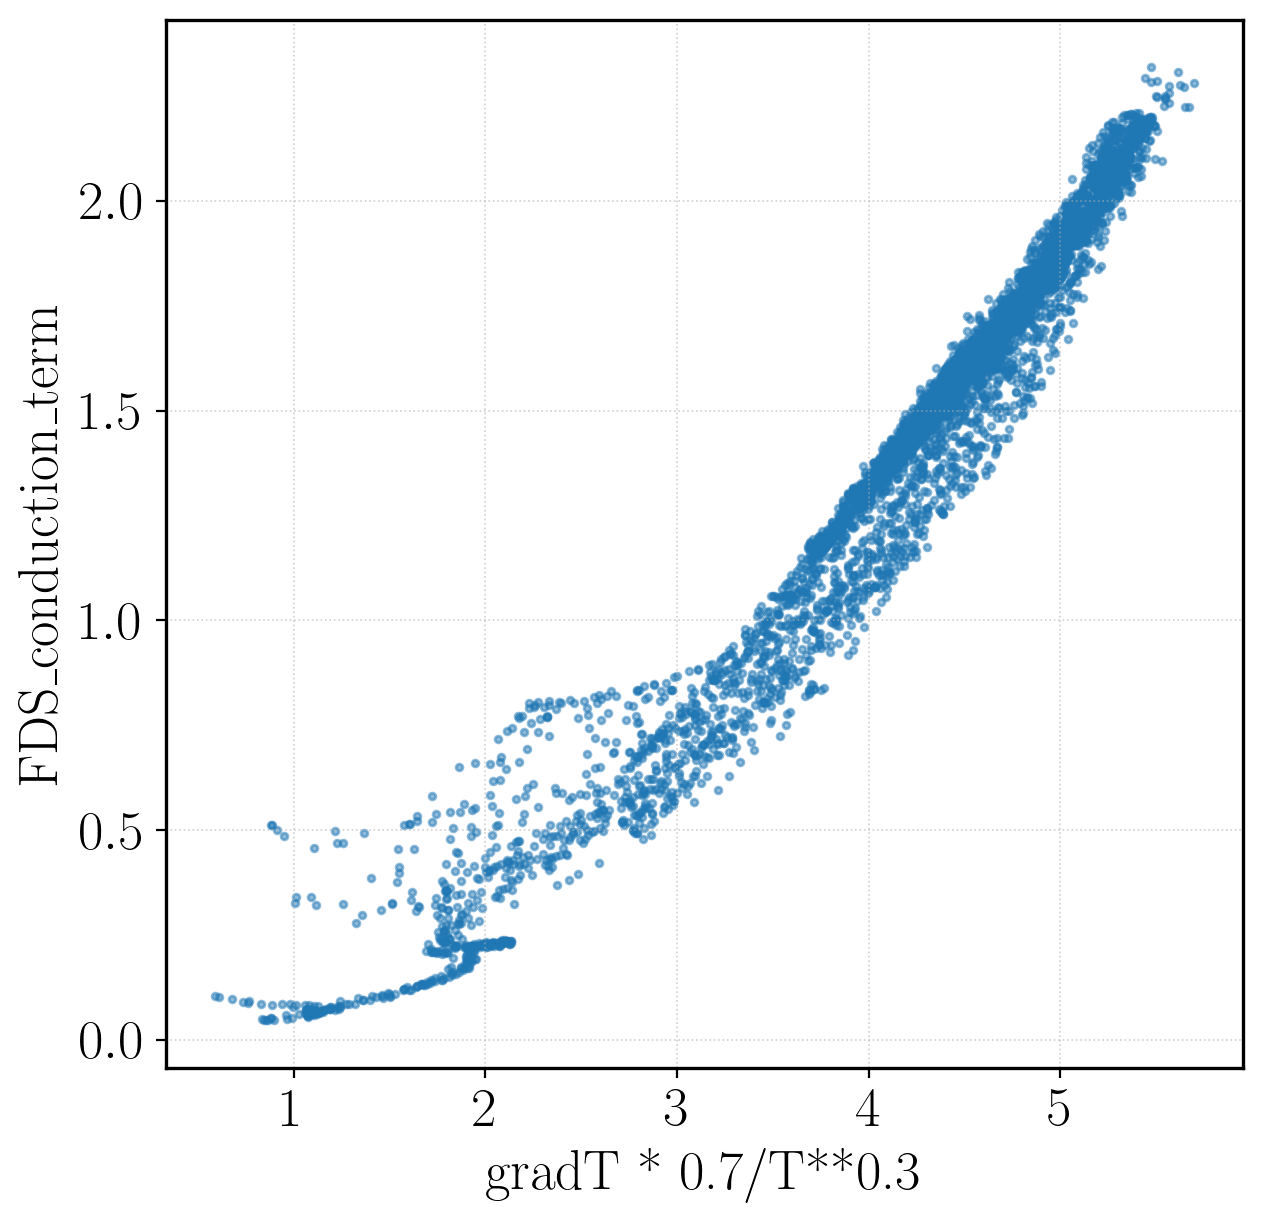

In [21]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[GRAD_T_COLUMN], dfv["FDS_source_term"],s=6, alpha=0.5)
ax.set_ylabel("FDS_conduction_term")
ax.set_xlabel("gradT * 0.7/T**0.3")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

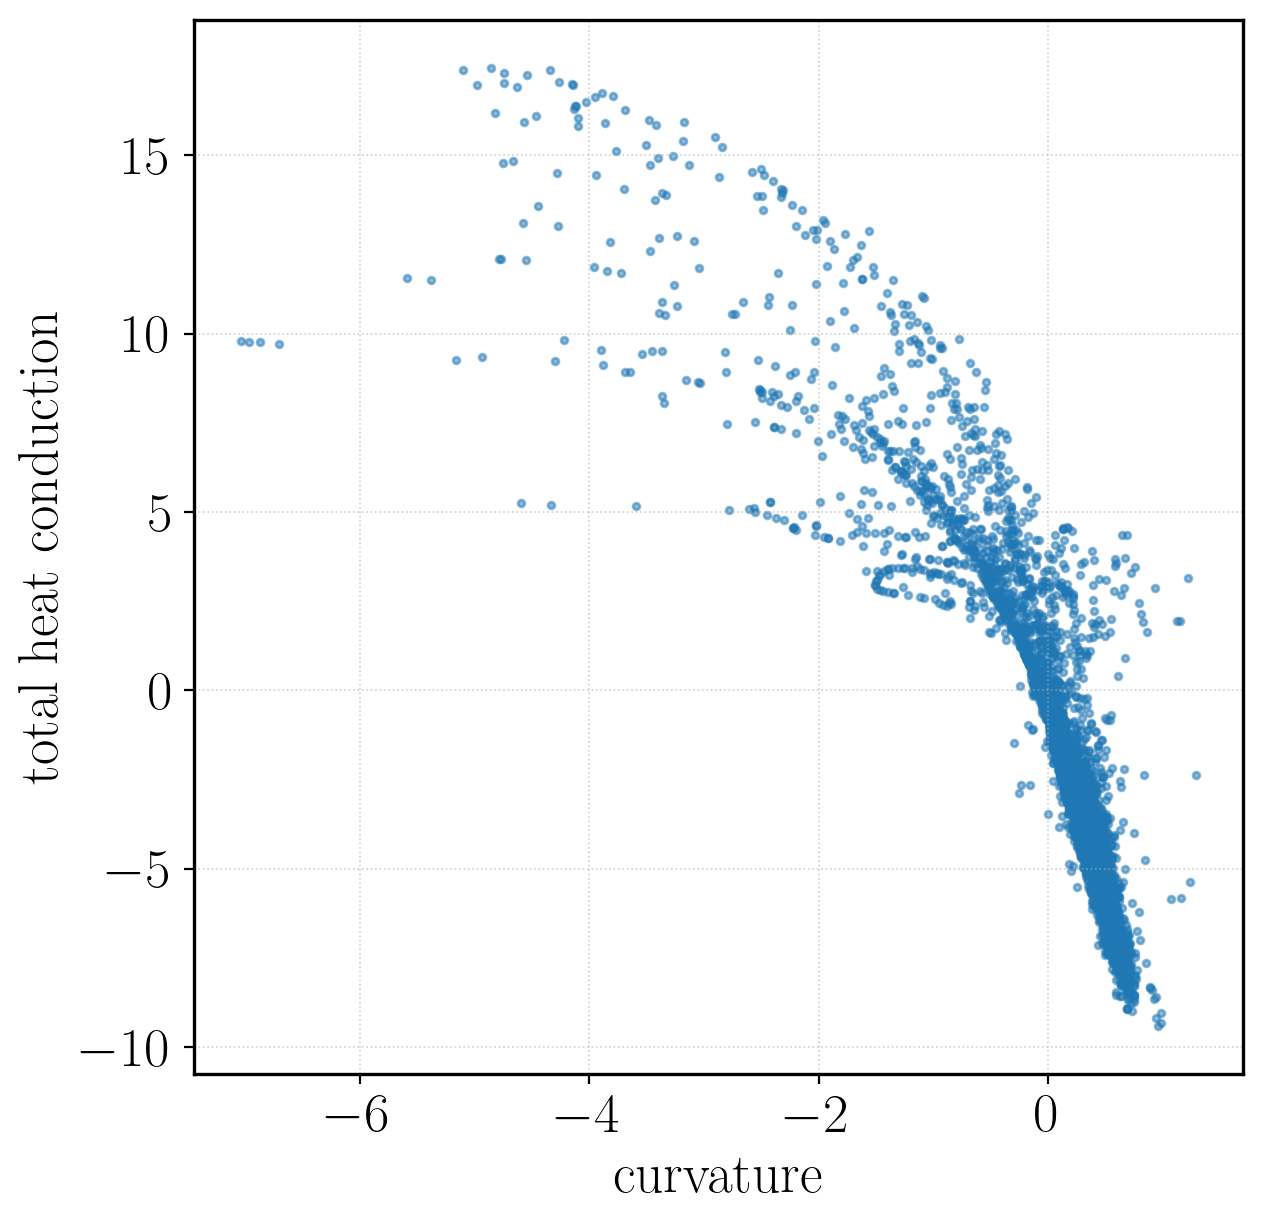

In [23]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[CURVATURE_COLUMN],dfv["total_heat_conduction"],s=6, alpha=0.5)
ax.set_ylabel("total heat conduction")
ax.set_xlabel("curvature")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()

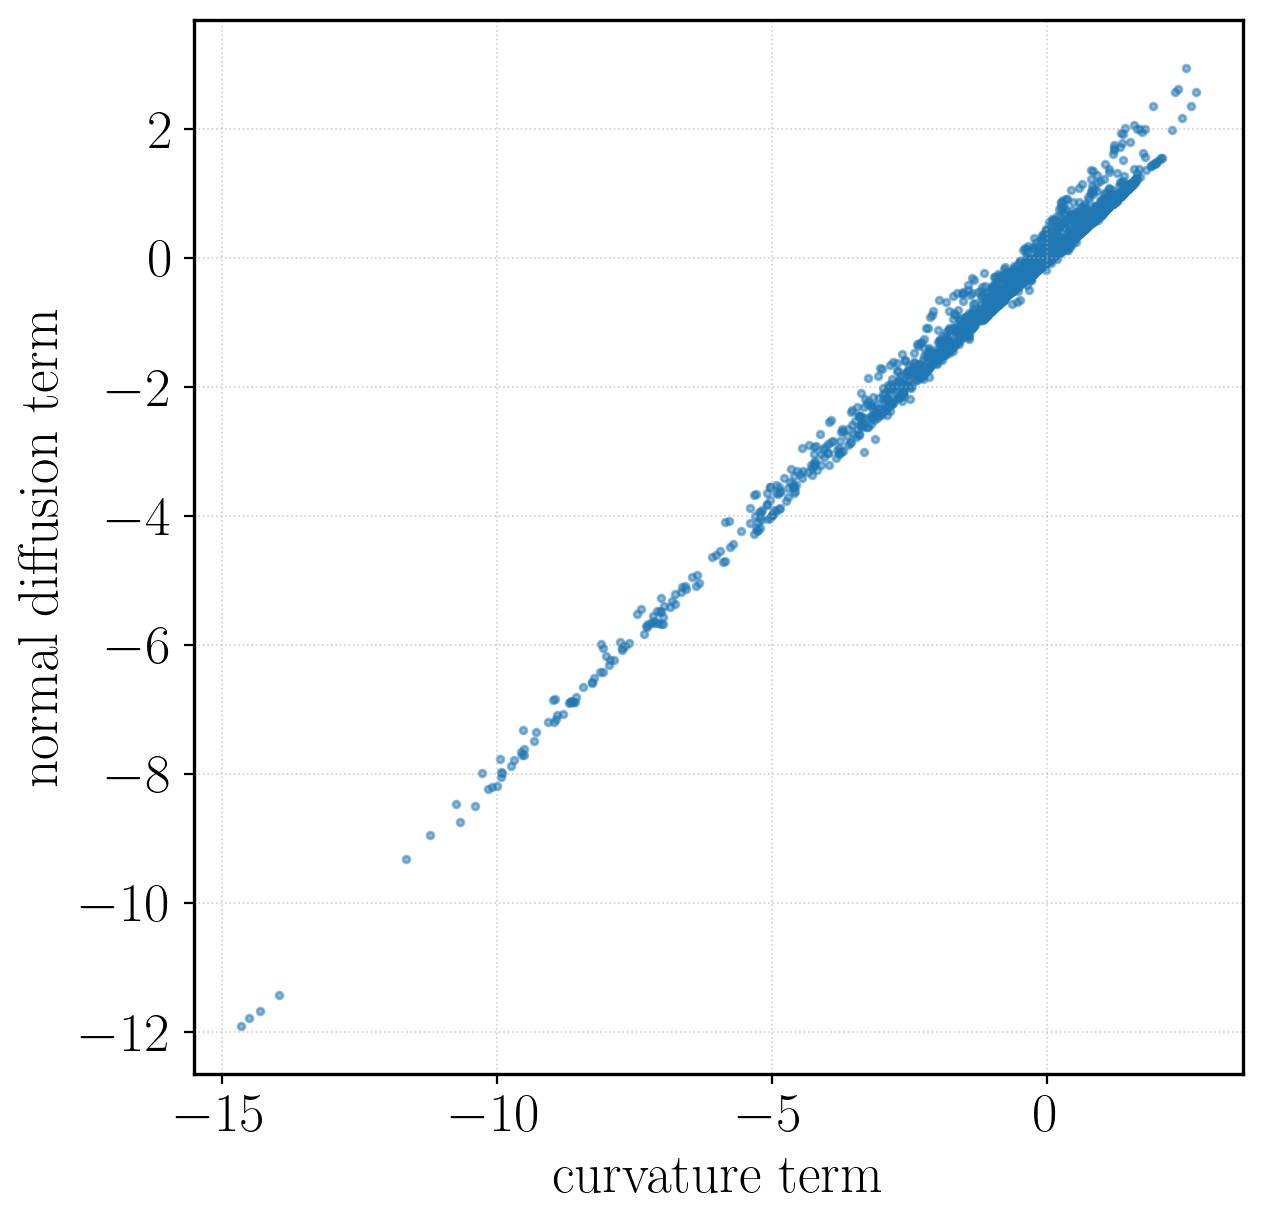

In [32]:
fig, ax = plt.subplots(figsize=(6.2, 6.0), dpi=200, constrained_layout=True)
plt.scatter(dfv[CURVATURE_COLUMN] * (dfv[DENSITY_COLUMN])**0.7, dfv["FDS_conduction_term"] + dfv[CURVATURE_COLUMN] * (dfv[DENSITY_COLUMN])**0.7  ,s=6, alpha=0.5)
ax.set_ylabel("normal diffusion term")
ax.set_xlabel("curvature term")
ax.grid(True, linestyle=":", linewidth=0.6, alpha=0.6)
plt.show()